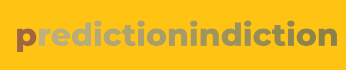


By Cao Qing Tian, Hrishikesh Pai and Karanam Akshit

## **Introduction and Dataset**

### ***Introduction***

PredictionIndiction is a **restaurant recommendation system** that goes beyond the usual notion of using attributes, such as cuisine and rating, to generate recommendation solely based on the restaurants the user has visited. Instead, PredictionIndiction also **takes into account the restaurants his friends have visited**.

Recent research has shown that friends may be similar due to peer influence or diffusion: the tendency for characteristics and behaviors to spread through social ties such that friends increasingly resemble one another over time  (Centola D ,2010). So, the underlying assumption of this recommender is that **friends have similar tastes**. 


##### ***Our Identity***
**Prediction**: a thing predicted; a forecast

**Indiction**: a valuation of property made every 15 years as a basis for taxation. 

The name of our recommender exemplifies our aim to give precise and valuable predictions for users.

### ***Dataset***

For the purpose of this project, we started searching for databases that has details of friends for each user, and we found a dateset that exactly matched our needs: **The Yelp Dataset**

This dataset can be found on Kaggle by accessing this link:
https://www.kaggle.com/yelp-dataset/yelp-dataset

##### ***The Yelp Dataset***

This datset as found on kaggle contains 5 files (in json), but we are using these 3 files:
1. User Data
  - The User Data contains 2 key fields: **user_id** and **friends**
2. Business Data
  - The Business Data contains several key fields: **business_id**, **city** and its **various attributes**(such as cuisine and stars).
3. Reviews Data
  - Contains **user_id**, **business_id**, **stars**, **text**. 


## **Import Relevant Modules**

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import ast
from sklearn.metrics import accuracy_score
sns.set()
!pip install twython
from sklearn.metrics.pairwise import pairwise_distances
from sklearn.decomposition import PCA
!pip install pyathena
from pyathena import connect
import boto3
import gc
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics import accuracy_score



## FOR NLP
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
nltk.download('vader_lexicon')
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('words')
from string import punctuation
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from textblob import TextBlob
nltk.download('brown')
from nltk.stem.snowball import SnowballStemmer
stemmer = SnowballStemmer("english")
from nltk.corpus import wordnet
import string
from nltk import pos_tag
from nltk.corpus import stopwords
from nltk.tokenize import WhitespaceTokenizer
from nltk.stem import WordNetLemmatizer
from wordcloud import WordCloud



     |████████████████████████████████| 133kB 5.0MB/s 
ERROR: datascience 0.10.6 has requirement folium==0.2.1, but you'll have folium 0.8.3 which is incompatible.
  Found existing installation: urllib3 1.26.4
    Uninstalling urllib3-1.26.4:
      Successfully uninstalled urllib3-1.26.4


[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Package words is already up-to-date!
[nltk_data] Downloading package brown to /root/nltk_data...
[nltk_data]   Package brown is already up-to-date!


In [ ]:
## No need to run if running locally. If you are using Google Collab, run this.
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## **Data Pre-Processing**


#### **SQL Query** (NO NEED TO RUN AGAIN)

As usual, we tried to import the relevant datsets into different pandas DataFrame. However, the size of the datasets are quite huge.

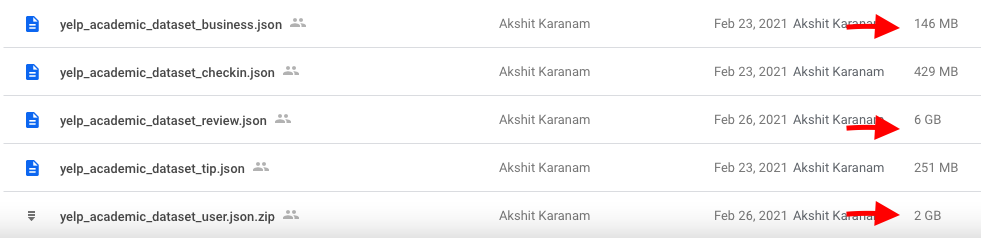


As you can see here if we load these datasets into a pandas DataFrame, that would take up over 8GB of RAM. Since Google Collab's RAM is limited to 12GB, it was impossible for us to do any further computation. Hence, we had to workaround and come up with a way where we have to somehow extract a relevant small portion of data from these huge dataset.

To solve this problem, we decided to store these data into a database, and then use SQL queries to query the relevant data, as needed. The easiest way to implement this was to use AWS Athena. This is how it works:

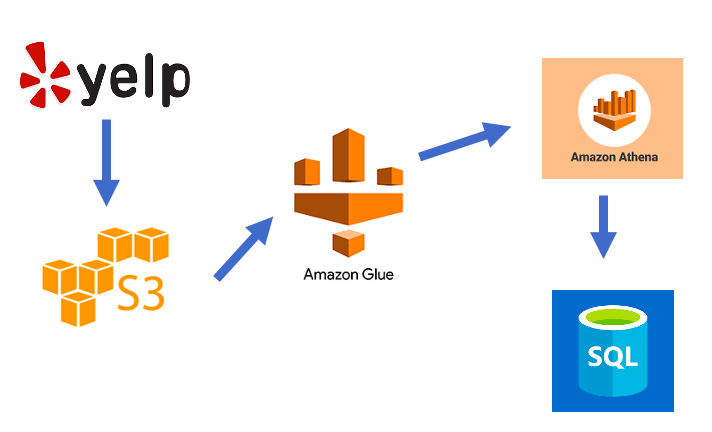

In [ ]:
# To connect to AWS Athena (We have removed the access_key info, If you do need it, please refer to the readme file.)
cursor = connect(aws_access_key_id='##############',
                 aws_secret_access_key='############',
                 s3_staging_dir='s3://athena-query-self/',
                 region_name='ap-southeast-1').cursor()

This was our initial plan:

1. Get the User ID of the user
2. Get the list of friends for that User
3. Get all Reviews for that user
4. Get all Reviews for each friend
5. Store all these information in a pandas DataFrame

In [ ]:
# Query from AWS Athena
cursor.execute(''' SELECT * FROM "sampledb"."userdata_yelp" LIMIT 1 ''')
from pyathena.pandas.util import as_pandas
test_data = as_pandas(cursor)

In [ ]:
test_data.head()

,user_id,name,review_count,yelping_since,useful,funny,cool,elite,friends,fans,average_stars,compliment_hot,compliment_more,compliment_profile,compliment_cute,compliment_list,compliment_note,compliment_plain,compliment_cool,compliment_funny,compliment_writer,compliment_photos
0,8pH5Y22GFffnaWdrDWhtMw,SunnyAndLeonard,109,2013-06-09 16:19:33,61,26,45,,"S90p6VP0HvFTQUZ00dUmww, NNL1zLTP2J_SOputgoPYeQ...",0,3.49,0,0,0,0,0,1,0,1,1,1,1


In [ ]:
# Split it into a list(STRING -> List)
test_data['friends'][0] = test_data['friends'][0].split(',')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [ ]:
friendsList = test_data['friends'][0]
friendsList[0]

'S90p6VP0HvFTQUZ00dUmww'

In [ ]:
# Getting review data for the first friend (FROM THE Previous CELL)
cursor.execute(''' SELECT * FROM "sampledb"."reviewdata_yelp" WHERE user_id = 'S90p6VP0HvFTQUZ00dUmww' ''') #using the friend (output) from previous cell
test_data_2 = as_pandas(cursor)
test_data_2.head()

# This gives an empty response, however, that's of course expected, not all users write reviews!


,review_id,user_id,business_id,stars,useful,funny,cool,text,date


In [ ]:
# Getting user data for the first friend, just to see if user exists in the User dataset
cursor.execute(''' SELECT * FROM "sampledb"."userdata_yelp" WHERE user_id = 'S90p6VP0HvFTQUZ00dUmww' ''')
test_data_3 = as_pandas(cursor)
test_data_3.head()

# Strangely, this gives an empty response as well. This friend does not exist in the User dataset, 
# which suggests that the user dataset given does not contain information for all Users.

# We have also observed a similar pattern in the Review Dataset. The user exists in the Review Dataset but does not exist in the User Dataset

,user_id,name,review_count,yelping_since,useful,funny,cool,elite,friends,fans,average_stars,compliment_hot,compliment_more,compliment_profile,compliment_cute,compliment_list,compliment_note,compliment_plain,compliment_cool,compliment_funny,compliment_writer,compliment_photos


**PROBLEM?**

At this point, we realised that **querying data** from AWS is actually quite **expensive.** It costs $20/ 4TB of data scanned. Since our data is about 10GB in total, that means for **every query**, we are going to pay **5 cents**. That would be extremely expensive since for some users, they have over 100 friends itself! So, we had to think of a way where we could **reduce the number of queries** we were calling. In addition, we also realised that for some users, none of their friends have written any reviews, causing a sheer waste of computation. As mentioned previously, we also realised that not all friends' id given in user data exist in review dataset (meaning that not all friends have written reviews), and not all users have friends. 

Therefore, we use SQL Queries to locate users that:
- are friends and have written reviews
- User himself have written reviews

This is the way we decided to takle this problem:

1. Get a friendsList which is created by concatenating the "friends" value for each user.

2. Get friends_reviews from **Reviews Dataset** such that **user_id exists in friendsList**. 

3. Get user_reviews from **Reviews Dataset** such that **user_id exists in User Dataset**.

4. Get friends from **User Dataset** such that **user_id exists in Reviews Dataset**.

5. Get the resultant csv files, from the respective queries. These csv files, which are a subset of the larger datasets (significantly smaller size), then can be loaded into a pandas dataframe.

We decided to directly query on the AWS platform, rather than querying here, as we could directly download the resultant files in the csv format. These files are named **friends_reviews.csv** and **user_reviews.csv** and **user_data.csv** respectively.


This is how the SQL Query goes:

1. **To create friendsList**:
  <br>SELECT friends_split
    <br>FROM sampledb.userdata_yelp
    <br>CROSS JOIN UNNEST(SPLIT(friends,',')) AS t (friends_split))


2. **Get Relevant Reviews For Friends**:
<br>SELECT *
<br>FROM sampledb.reviewdata_yelp
<br>WHERE user_id IN 
  <br>  (SELECT friends_split
  <br>  FROM sampledb.userdata_yelp
  <br>  CROSS JOIN UNNEST(SPLIT(friends,',')) AS t (friends_split))

3. **Get Relevant Reviews For Users**:
<br>SELECT *
<br>FROM sampledb.reviewdata_yelp
<br>WHERE user_id IN 
<br>   (SELECT user_id
 <br>   FROM sampledb.userdata_yelp)
 
4. **Get Relevant Users**
<br>SELECT *
<br>FROM sampledb.userdata_yelp
<br>WHERE user_id IN 
 <br>   (SELECT user_id
 <br>   FROM sampledb.reviewdata_yelp)
















####**Data Cleaning** 

First, we load the csv files obtained from the SQL Queries from the previous section. 

Since we had 2 reviews datasets created (one for friends and one for users), we concatanate them together, and then remove duplicate reviews(by using the "review_id" column).

Next, we merge the user data with the review data. (Take note that we are doing a 'left' merge here). 

In [ ]:
user_reviews = pd.read_csv('/content/drive/MyDrive/CZ1016 Mini Project/user_reviews.csv')
friends_reviews = pd.read_csv('/content/drive/MyDrive/CZ1016 Mini Project/friends_reviews.csv')
df = pd.concat([user_reviews,friends_reviews])
user_data = pd.read_csv('/content/drive/MyDrive/CZ1016 Mini Project/user_data.csv')
df.drop_duplicates('review_id',inplace =True)
df_merged = pd.merge(left=df, right= user_data, how='left', left_on='user_id', right_on='user_id')

In [ ]:
df_merged.info(verbose=True, null_counts=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2427244 entries, 0 to 2427243
Data columns (total 30 columns):
 #   Column              Non-Null Count    Dtype  
---  ------              --------------    -----  
 0   review_id           2427244 non-null  object 
 1   user_id             2427244 non-null  object 
 2   business_id         2427244 non-null  object 
 3   stars               2427244 non-null  float64
 4   useful_x            2427244 non-null  int64  
 5   funny_x             2427244 non-null  int64  
 6   cool_x              2427244 non-null  int64  
 7   text                2427244 non-null  object 
 8   date                2427244 non-null  object 
 9   name                2021226 non-null  object 
 10  review_count        2021226 non-null  float64
 11  yelping_since       2021226 non-null  object 
 12  useful_y            2021226 non-null  float64
 13  funny_y             2021226 non-null  float64
 14  cool_y              2021226 non-null  float64
 15  elite          

The output of .info() above shows that there are 2,427,244 reviews but only 2,021,226 of them have users in the user dataset. Hence, we can be assured that the above SQL Query has indeed worked, as it was successful in getting reviews of users that were not present in the user dataset. These reviews are valuable for us, as these 'extra' reviews are written by some friend 'y' of some user 'x'.


---



In [ ]:
# Now, lets load the Raw Business data obtained from Kaggle. 
biz_data = pd.read_json('/content/drive/MyDrive/CZ1016 Mini Project/yelp_academic_dataset_business.json',lines=True)
# biz_data['categories'] = biz_data.categories.apply(lambda x: x.split(','))
biz_data = biz_data[biz_data['categories'].str.contains('Restaurant.*',regex=True)==True].reset_index()
biz_data = biz_data.drop(columns = 'index')

In [ ]:
# Only obtain reviews of business that are restaurants. We are doing an 'inner' merge to get the intersection
review_final = df_merged.merge(biz_data[['business_id']], how='inner', on='business_id')
review_final = review_final.drop_duplicates(subset=['review_id'])

In [ ]:
# Do not run again
%cd /content/drive/MyDrive/CZ1016 Mini Project
review_final.to_csv('restaurant_review.csv')

In [ ]:
review_final.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1647857 entries, 0 to 1647856
Data columns (total 30 columns):
 #   Column              Non-Null Count    Dtype  
---  ------              --------------    -----  
 0   review_id           1647857 non-null  object 
 1   user_id             1647857 non-null  object 
 2   business_id         1647857 non-null  object 
 3   stars               1647857 non-null  float64
 4   useful_x            1647857 non-null  int64  
 5   funny_x             1647857 non-null  int64  
 6   cool_x              1647857 non-null  int64  
 7   text                1647857 non-null  object 
 8   date                1647857 non-null  object 
 9   name                1381693 non-null  object 
 10  review_count        1381693 non-null  float64
 11  yelping_since       1381693 non-null  object 
 12  useful_y            1381693 non-null  float64
 13  funny_y             1381693 non-null  float64
 14  cool_y              1381693 non-null  float64
 15  elite          

In [ ]:
# Only get restaurants data that are present in reviews_final
restaurants_df = biz_data.merge(review_final[['business_id']], how='inner', on='business_id')
restaurants_df = restaurants_df.drop_duplicates(subset=['business_id'])


In [ ]:
# Dont' Run Again!
%cd /content/drive/MyDrive/CZ1016 Mini Project
restaurant_df.to_csv('restaurant_final.csv')

In [ ]:
del user_reviews
del friends_reviews
del df
del user_data
del df_merged
gc.collect()

52

Now, we have 2 DataFrames - Restaurants and Reviews. The reviews dataset has been merged to include the user data for each review. These are the base datasets we are going to start working on to further enhance and clean the data. 

In [ ]:
reviews_df = review_final[['review_id','user_id','business_id','stars','text','friends','date']]
del review_final
gc.collect()


50

In [ ]:
reviews_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1647857 entries, 0 to 1647856
Data columns (total 7 columns):
 #   Column       Non-Null Count    Dtype  
---  ------       --------------    -----  
 0   review_id    1647857 non-null  object 
 1   user_id      1647857 non-null  object 
 2   business_id  1647857 non-null  object 
 3   stars        1647857 non-null  float64
 4   text         1647857 non-null  object 
 5   friends      1381693 non-null  object 
 6   date         1647857 non-null  object 
dtypes: float64(1), object(6)
memory usage: 100.6+ MB


We now have relevant restaurant data (restaurants_df) and its corresponding reviews (reviews_df).

However, we still need to sort out the friends for each user, such that friends who have not written any reviews are eliminated.

In [ ]:
reviews_df = reviews_df.fillna("")
uniqueUsersDF = reviews_df.copy().drop_duplicates('user_id')
uniqueUsersDF = uniqueUsersDF.drop(columns=['review_id','business_id','stars','text','date'])
uniqueUsersDF["friends"] = uniqueUsersDF.friends.apply(lambda x: x.split(', '))
friendsList = uniqueUsersDF['user_id'].tolist()
friendsList = set(friendsList)


def checkFriendExists(rawFriendList,friendsList):
  realFriendsList = []
  list(map(lambda x: realFriendsList.append(x) if x in friendsList else None,rawFriendList ))
  return realFriendsList
  
uniqueUsersDF["realFriends"] = uniqueUsersDF['friends'].apply(lambda x: checkFriendExists(x,friendsList))
uniqueUsersDF = uniqueUsersDF.drop(columns=['friends'])
reviews_df = reviews_df.drop(columns=['friends'])
reviews_df = reviews_df.merge(uniqueUsersDF,how='inner',on='user_id')

del friendsList
del uniqueUsersDF
gc.collect() 

0



---




Now, lets clean and organise the restaurants dataset (restaurants_df)

In [ ]:
restaurants_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 60166 entries, 0 to 1647818
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   business_id   60166 non-null  object 
 1   name          60166 non-null  object 
 2   address       60166 non-null  object 
 3   city          60166 non-null  object 
 4   state         60166 non-null  object 
 5   postal_code   60166 non-null  object 
 6   latitude      60166 non-null  float64
 7   longitude     60166 non-null  float64
 8   stars         60166 non-null  float64
 9   review_count  60166 non-null  int64  
 10  is_open       60166 non-null  int64  
 11  attributes    58984 non-null  object 
 12  categories    60166 non-null  object 
 13  hours         48172 non-null  object 
dtypes: float64(3), int64(2), object(9)
memory usage: 6.9+ MB



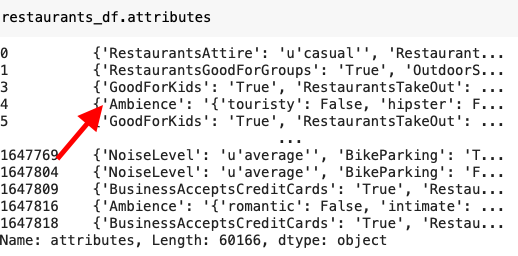


As you can see, the restaurant attributes are in dictionaries. However, we realised that for some restaurants the attributes dictionary contains inner nested dictionaries, such as that of 'ambience'. We have noticed 6 such inner nested dictionaries:
- Business Parking
- Ambience
- GoodForMeal
- DietaryRestrictions
- Music
- BestNights





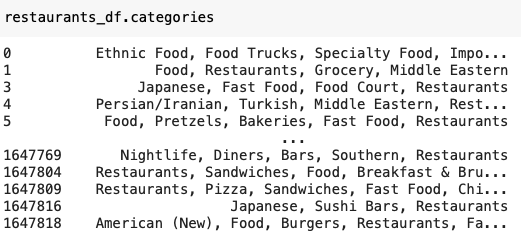


For the restaurant categories, it is more simple as it is in the form of string seperated by a comma.

The below function (getDummiesForRestaurants) gets dummies for both the attributes and categories to perform something similar to a one-hot encoding.




---




In [ ]:
def get_key_value(attribute, key):

    if attribute == None: 
        return {}

    if key in attribute:
        return ast.literal_eval(attribute.pop(key)) 
    else:
        return {};
def getDummiesForRestaurants(restaurants):
  
  restaurants['BusinessParking'] = restaurants.apply(
      lambda x: get_key_value(x['attributes'], 'BusinessParking'), axis=1)

  restaurants['Ambience'] = restaurants.apply(
      lambda x: get_key_value(x['attributes'], 'Ambience'), axis=1)

  restaurants['GoodForMeal'] = restaurants.apply(
      lambda x: get_key_value(x['attributes'], 'GoodForMeal'), axis=1)

  restaurants['DietaryRestrictions'] = restaurants.apply(
      lambda x: get_key_value(x['attributes'], 'DietaryRestrictions'), axis=1)

  restaurants['Music'] = restaurants.apply(
      lambda x: get_key_value(x['attributes'], 'Music'), axis=1)

  restaurants['BestNights'] = restaurants.apply(
      lambda x: get_key_value(x['attributes'], 'BestNights'), axis=1)


  restaurants = restaurants.dropna(subset=['attributes'])

  attributesDF = pd.concat([restaurants['attributes'].apply(pd.Series), 
                          restaurants['BusinessParking'].apply(pd.Series),
                          restaurants['Ambience'].apply(pd.Series),
                          restaurants['GoodForMeal'].apply(pd.Series), 
                          restaurants['DietaryRestrictions'].apply(pd.Series),
                          restaurants["Music"].apply(pd.Series),
                          restaurants['BestNights'].apply(pd.Series)], axis=1)
  
  attributesDF_dummies = pd.get_dummies(attributesDF)
  attributesDF_dummies.head()
  attributesDF_dummies = attributesDF_dummies.fillna(0)
  categoriesDF = pd.Series(restaurants['categories']).str.get_dummies(",")
  categoriesDF = categoriesDF.fillna(0)
  categoriesDF=categoriesDF*1
  attributesDF_dummies=attributesDF_dummies*1
  restaurantPropDF = restaurants[['name','stars','business_id','city']]
  final_df_restaurant = pd.concat([categoriesDF,
                                 attributesDF_dummies,restaurantPropDF], axis = 1)
  
  return final_df_restaurant 


In [ ]:
restaurants_df = getDummiesForRestaurants(restaurants_df)
gc.collect()

48

In [ ]:
restaurants_df.head()


,& Probates,Acai Bowls,Accessories,Accountants,Acne Treatment,Active Life,Adult Education,Adult Entertainment,Advertising,Afghan,African,Air Duct Cleaning,Aircraft Repairs,Airport Lounges,Airport Shuttles,Airports,Airsoft,Alternative Medicine,Amateur Sports Teams,American (New),American (Traditional),Amusement Parks,Animal Assisted Therapy,Animal Physical Therapy,Animal Shelters,Antiques,Apartments,Appliances,Appliances & Repair,Aquarium Services,Aquariums,Arabian,Arcades,Archery,Argentine,Armenian,Art Classes,Art Galleries,Art Museums,Art Schools,...,intimate_True,trendy_False,trendy_True,upscale_False,upscale_True,classy_False,classy_True,casual_False,casual_True,divey_False,divey_True,dessert_False,dessert_True,latenight_False,latenight_True,lunch_False,lunch_True,dinner_False,dinner_True,brunch_False,brunch_True,breakfast_False,breakfast_True,dj_False,dj_True,background_music_False,background_music_True,no_music_False,jukebox_False,jukebox_True,live_False,live_True,video_False,video_True,karaoke_False,karaoke_True,name,stars,business_id,city
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,The Empanadas House,4.5,pQeaRpvuhoEqudo3uymHIQ,Champaign
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,Middle East Deli,3.0,CsLQLiRoafpJPJSkNX2h5Q,Charlotte
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,Banzai Sushi,4.5,lu7vtrp_bE9PnxWfA8g4Pg,Thornhill
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,1,0,1,0,1,0,1,0,0,0,1,0,1,0,1,0,1,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,Apadana Restaurant,3.0,9sRGfSVEfLhN_km60YruTA,Richmond Hill
5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,1,0,1,0,1,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,Wetzel's Pretzels,4.0,vjTVxnsQEZ34XjYNS-XUpA,Phoenix


Next, we have decided to give an average sentiment score, based on  the reviews written, for each business, and we hope that it gives a more realistic rating.

This is the logic behind the code executed below:

1. Get **sentimentScore** for **each review** in review_df
2. Get **totalSentimentScore** by **adding sentimentScore** and **'stars'** in review dataset.
3. Calculate **averageScore** by taking the average of totalSentimentScore **for each business.**
4. Calculate **totalScore** for each business by a**dding averageScore and 'stars' in business dataset**.
5. Now, we have a **score rating** of each restuarant, with a **range of 0-15**.

In [ ]:
reviews_df.shape[0]

1647857

In [ ]:
## This is going to take long time to run!
sentiment = SentimentIntensityAnalyzer()
start = 0;
end = 100000
reviews2_df = pd.DataFrame()

while end<1700000:

  tempDF = reviews_df.loc[start:end]
  # Since Vader returns a score between -1 to 1, we will scale to make it a score rating out of 5.
  tempDF['sentimentScore'] = reviews_df.loc[start:end]['text'].apply(lambda x: (sentiment.polarity_scores(x)['compound'] + 1) *(5/2))
  reviews2_df = pd.concat([reviews2_df,tempDF])
  print(end)
  start += 100000
  end += 100000


In [ ]:
tempDF = reviews_df.loc[1600000:1647859]
tempDF['sentimentScore'] = reviews_df.loc[1600000:1647859]['text'].apply(lambda x: (sentiment.polarity_scores(x)['compound'] + 1) *(5/2))
reviews2_df = pd.concat([reviews2_df,tempDF])
reviews2_df

In [ ]:
reviews2_df = reviews2_df.drop_duplicates('review_id')

In [ ]:
reviews2_df.shape

(1647857, 7)

In [ ]:
reviews_df = reviews2_df
reviews_df.shape
del reviews_df2
del reviews2_df
gc.collect()

In [ ]:
reviews_df['totalSentimentScore'] = reviews_df['sentimentScore'] + reviews_df['stars']

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [ ]:
reviews_df['averageScore'] = reviews_df.copy()[["business_id","totalSentimentScore"]].groupby('business_id')['totalSentimentScore'].transform('mean')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [ ]:
reviews_df.head()

,review_id,user_id,business_id,stars,text,realFriends,sentimentScore,totalSentimentScore,averageScore
0,Oyfn6OGRXwN9QtVyDj1v9Q,ZJ6sj1IjdwmPPL_ZxmRKgw,OQvChaBImI8X5B3aai8btg,5.0,OMG! Was this a good choice after a 40 min wai...,"[M_BBueFMb3hBOMisaj1krw, XD8zIa8e2JjDyEHKefdOL...",4.81675,9.81675,8.270505
1,JofhvaqNHE2nuZLgP46UwQ,ZJ6sj1IjdwmPPL_ZxmRKgw,4X9tVVQHIewliXqaancfQA,3.0,Undecided about two options (sandwich Cubano o...,"[M_BBueFMb3hBOMisaj1krw, XD8zIa8e2JjDyEHKefdOL...",3.16225,6.16225,5.441527
2,ILVQ8h3RmBu_2CRscpfJGA,ZJ6sj1IjdwmPPL_ZxmRKgw,HC8hCn9rJB5EEgiNHpb6WQ,3.0,I wish I had seen the reviews before I purchas...,"[M_BBueFMb3hBOMisaj1krw, XD8zIa8e2JjDyEHKefdOL...",4.92375,7.92375,6.106556
3,s5wnUdAx3x4vrV8MBp8-5w,DvFDfCst0pWyvjG-xkWFTQ,OQvChaBImI8X5B3aai8btg,4.0,I'll caveat this post with the fact that the w...,"[ASYKogkXsc1yM__khxGScw, KKblXUNxSGCewpDxiiSRQ...",4.72125,8.72125,8.270505
4,8R-PiseDMgsIwRYp3eiwqA,DvFDfCst0pWyvjG-xkWFTQ,u4sTiCzVeIHZY8OlaL346Q,5.0,"My friends and I had a great visit to ""Gaucho""...","[ASYKogkXsc1yM__khxGScw, KKblXUNxSGCewpDxiiSRQ...",4.98400,9.98400,9.187436


In [ ]:
sentimentAnalysisForBiz = reviews_df.copy()[['business_id','averageScore']]
sentimentAnalysisForBiz = sentimentAnalysisForBiz.drop_duplicates('business_id')
restaurants_df = restaurants_df.merge(sentimentAnalysisForBiz,how='inner',on='business_id')
restaurants_df['totalScore'] = restaurants_df['stars'] + restaurants_df['averageScore']

In [ ]:
restaurants_df.head()

,& Probates,Acai Bowls,Accessories,Accountants,Acne Treatment,Active Life,Adult Education,Adult Entertainment,Advertising,Afghan,African,Air Duct Cleaning,Aircraft Repairs,Airport Lounges,Airport Shuttles,Airports,Airsoft,Alternative Medicine,Amateur Sports Teams,American (New),American (Traditional),Amusement Parks,Animal Assisted Therapy,Animal Physical Therapy,Animal Shelters,Antiques,Apartments,Appliances,Appliances & Repair,Aquarium Services,Aquariums,Arabian,Arcades,Archery,Argentine,Armenian,Art Classes,Art Galleries,Art Museums,Art Schools,...,trendy_True,upscale_False,upscale_True,classy_False,classy_True,casual_False,casual_True,divey_False,divey_True,dessert_False,dessert_True,latenight_False,latenight_True,lunch_False,lunch_True,dinner_False,dinner_True,brunch_False,brunch_True,breakfast_False,breakfast_True,dj_False,dj_True,background_music_False,background_music_True,no_music_False,jukebox_False,jukebox_True,live_False,live_True,video_False,video_True,karaoke_False,karaoke_True,name,stars,business_id,city,averageScore,totalScore
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,The Empanadas House,4.5,pQeaRpvuhoEqudo3uymHIQ,Champaign,9.841500,14.341500
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,Middle East Deli,3.0,CsLQLiRoafpJPJSkNX2h5Q,Charlotte,5.964250,8.964250
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,Banzai Sushi,4.5,lu7vtrp_bE9PnxWfA8g4Pg,Thornhill,4.358000,8.858000
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,1,0,1,0,1,0,0,0,1,0,1,0,1,0,1,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,Apadana Restaurant,3.0,9sRGfSVEfLhN_km60YruTA,Richmond Hill,7.312500,10.312500
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,1,0,1,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,Wetzel's Pretzels,4.0,vjTVxnsQEZ34XjYNS-XUpA,Phoenix,9.275125,13.275125


In [ ]:
%cd /content/drive/MyDrive/CZ1016 Mini Project
restaurants_df.to_csv('restaurant_withSA2.csv')


/content/drive/.shortcut-targets-by-id/10qhF7-iNaenqXqm8hP7LQqIQMbsSaFGU/CZ1016 Mini Project


##**Exploratory Data Analysis**

This section is **intended to give us a better understanding** and **intuition** of the dataset itself.

We tried to answer these 5 questions:

1. Does the **location**(which city the restaurant is loacated in) affect its rating?

2. Do **users** with **more reviews** give a better rating?

3. Does the **time or date** of the review written matter?

4. What **kind of words** are used in top-rated reviews?

5. What **differentiates** a 'good' and 'bad' restaurant?

Here, we are just going to load the previously cleaned csv files into pandas DataFrames, where **reviews_df** shows all the reviews, and **restaurants_df** shows the restaurant attributes.

In [ ]:
reviews_df = pd.read_csv('/content/drive/MyDrive/CZ1016 Mini Project/restaurant_review.csv')

In [ ]:
restaurants_df = pd.read_csv('/content/drive/MyDrive/CZ1016 Mini Project/restaurant_withSA2.csv')
restaurants_df = restaurants_df.drop(columns='Unnamed: 0')

#### ***Restaurant Location***

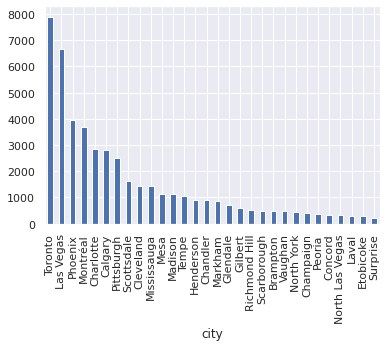

In [ ]:
restaurants_city_count = restaurants_df.copy().groupby('city').count()
restaurants_city_count = restaurants_city_count['name']
restaurants_city_count = restaurants_city_count.sort_values(ascending=False)
restaurants_city_count[:30].plot(kind='bar')

Las Vegas and Toronto have the most reviews!


In [ ]:
cityDF = restaurants_df.copy()[['city']].drop_duplicates('city')

In [ ]:
cityDF['city']

0             Champaign
1             Charlotte
2             Thornhill
3         Richmond Hill
4               Phoenix
              ...      
58262           Central
58392          Crescent
58684          Downtown
58771    Montreal-Ouest
58923    Cote-Saint-Luc
Name: city, Length: 750, dtype: object

In [ ]:
def getAverageRatingOfCity(city,restaurants_df):
  restaurantsInCity = restaurants_df[restaurants_df['city'] == str(city)]
  return sum(restaurantsInCity['totalScore'].tolist())/restaurantsInCity.shape[0]

In [ ]:
cityDF["AverageRating"] = cityDF['city'].apply(lambda x: getAverageRatingOfCity(x,restaurants_df))

In [ ]:
cityDF.sort_values(by='AverageRating',ascending=False).reset_index(drop=True)

,city,AverageRating
0,Whitaker,14.963750
1,Godmanchester,14.895250
2,Côte-Saint-Luc,14.877000
3,Les Coteaux,14.835500
4,Saint-Pierre-de-Véronne-à-Pike-River,14.800000
...,...,...
745,Pont-Viau,3.561500
746,S.Euclid,3.437094
747,Omaha,3.225250
748,Beloeil,3.145000


In [ ]:
rating = pd.DataFrame(cityDF['AverageRating'])
print("Data type : ", type(rating))
print("Data dims : ", rating.size)
rating.head()

Data type :  <class 'pandas.core.frame.DataFrame'>
Data dims :  750


,AverageRating
0,10.583366
1,11.051396
2,10.977722
3,10.767930
4,11.144340


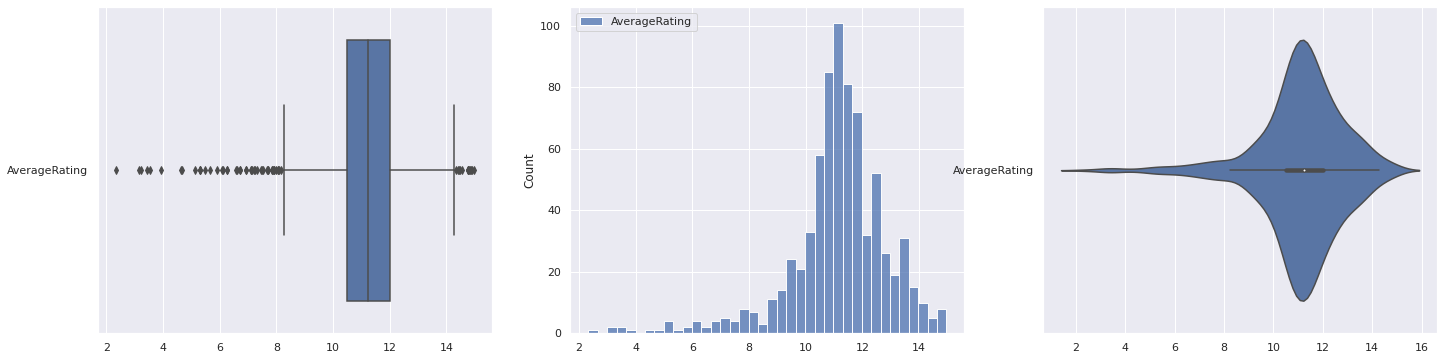

In [ ]:
# Set up matplotlib figure with three subplots
f, axes = plt.subplots(1, 3, figsize=(24, 6))

# Plot the basic uni-variate figures for HP
sns.boxplot(data = rating, orient = "h", ax = axes[0])
sns.histplot(data = rating, ax = axes[1])
sns.violinplot(data = rating, orient = "h", ax = axes[2])

In [ ]:
rating.describe()

,AverageRating
count,750.000000
mean,11.119727
std,1.761646
min,2.336000
25%,10.500162
50%,11.233333
75%,12.020285
max,14.963750


As seen from the the plots, a **large proportion** of ratings lie **between 10 and 15**, and the **standard deviation** is relatively small at **1.76**.  Hence, we can see that there is **not a huge variation** between the **restaurants rating across different cities**. This is a key factor that has to be taken note of.

#### ***User-reviews frequency***

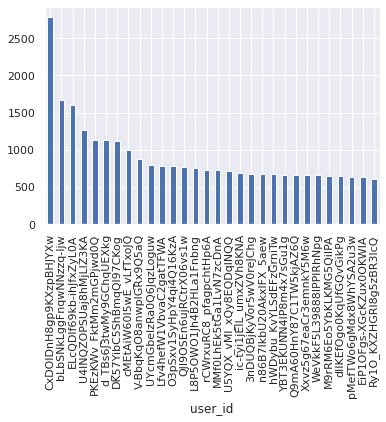

In [ ]:
user_review_count = reviews_df.copy().groupby('user_id').count()
user_review_count = user_review_count['review_id']
user_review_count = user_review_count.sort_values(ascending=False)
user_review_count[:30].plot(kind='bar')

In [ ]:
reviews_df["meanScore"] = reviews_df.copy()[["user_id","stars"]].groupby('user_id')['stars'].transform('mean')

In [ ]:
averageDF = reviews_df.copy()[["user_id","meanScore"]].drop_duplicates('user_id')

In [ ]:
averageDF = averageDF.merge(user_review_count,how='inner',on='user_id')

In [ ]:
averageDF.head()

,user_id,meanScore,review_id
0,ZJ6sj1IjdwmPPL_ZxmRKgw,3.666667,3
1,DvFDfCst0pWyvjG-xkWFTQ,4.600000,45
2,3kOgbmbI2DsbK85gYWsfOA,3.833333,6
3,HgtMpsgHaOuy7PbgbSqEYw,3.750000,12
4,HT6JHtJXlIYmxerxZA7Hkw,3.529412,17


In [ ]:
rating2 = pd.DataFrame(averageDF['meanScore'])
print("Data type : ", type(rating2))
print("Data dims : ", rating2.size)
rating2.head()

Data type :  <class 'pandas.core.frame.DataFrame'>
Data dims :  250195


,meanScore
0,3.666667
1,4.600000
2,3.833333
3,3.750000
4,3.529412


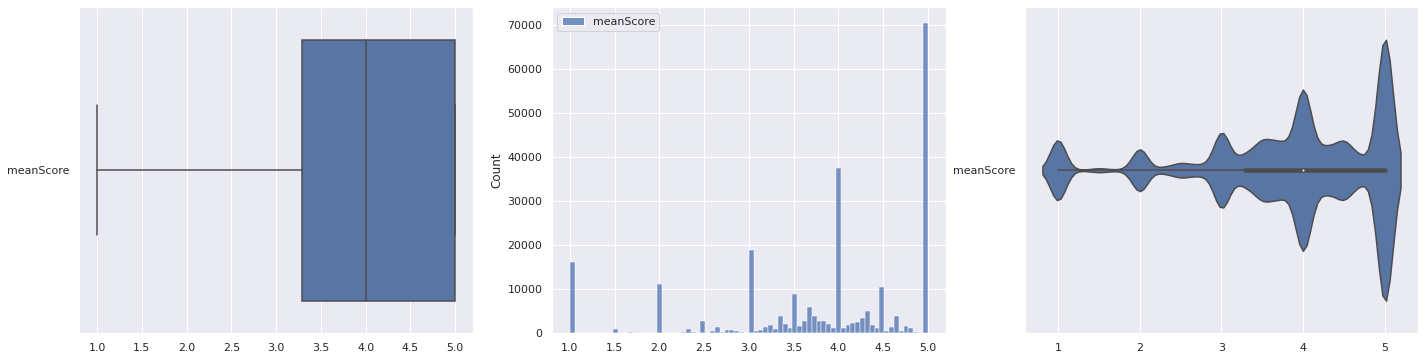

In [ ]:
f, axes = plt.subplots(1, 3, figsize=(24, 6))
sns.boxplot(data = rating2, orient = "h", ax = axes[0])
sns.histplot(data = rating2, ax = axes[1])
sns.violinplot(data = rating2, orient = "h", ax = axes[2])

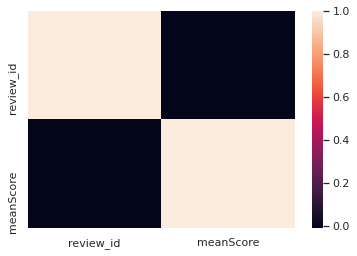

In [ ]:
corrDF = averageDF[['review_id','meanScore']]
sns.heatmap(corrDF.corr());

We can observe here that there is **no correlation** between the **number of reviews done by the user** and **his average rating**. Hence, we can conclude that the number of restaurants visited by a user does not affect his average rating.

#### ***Time-Series Data***






In this sub-section, we analyse if the year or time the review has been posted affects a restaurants ratings.

These are the 2 questions we are trying to answer here.

1. Does the **time** of the review matter?

2. Have restaurants **become 'better' over the years**? If yes, it means that 'old' reviews should be discarded.


Since, it is very time consuming to do analysis for all reviews, for the purpose of this project, we will take be only analysing the top 100 businesses (by review frequency count). 

In [ ]:
reviews_df.head()

,review_id,user_id,business_id,stars,text,date,realFriends
0,Oyfn6OGRXwN9QtVyDj1v9Q,ZJ6sj1IjdwmPPL_ZxmRKgw,OQvChaBImI8X5B3aai8btg,5.0,OMG! Was this a good choice after a 40 min wai...,2015-11-28 21:19:27,"[M_BBueFMb3hBOMisaj1krw, XD8zIa8e2JjDyEHKefdOL..."
1,JofhvaqNHE2nuZLgP46UwQ,ZJ6sj1IjdwmPPL_ZxmRKgw,4X9tVVQHIewliXqaancfQA,3.0,Undecided about two options (sandwich Cubano o...,2018-06-18 15:14:01,"[M_BBueFMb3hBOMisaj1krw, XD8zIa8e2JjDyEHKefdOL..."
2,ILVQ8h3RmBu_2CRscpfJGA,ZJ6sj1IjdwmPPL_ZxmRKgw,HC8hCn9rJB5EEgiNHpb6WQ,3.0,I wish I had seen the reviews before I purchas...,2019-06-06 21:26:08,"[M_BBueFMb3hBOMisaj1krw, XD8zIa8e2JjDyEHKefdOL..."
3,s5wnUdAx3x4vrV8MBp8-5w,DvFDfCst0pWyvjG-xkWFTQ,OQvChaBImI8X5B3aai8btg,4.0,I'll caveat this post with the fact that the w...,2018-12-26 14:17:40,"[ASYKogkXsc1yM__khxGScw, KKblXUNxSGCewpDxiiSRQ..."
4,8R-PiseDMgsIwRYp3eiwqA,DvFDfCst0pWyvjG-xkWFTQ,u4sTiCzVeIHZY8OlaL346Q,5.0,"My friends and I had a great visit to ""Gaucho""...",2019-01-16 04:18:58,"[ASYKogkXsc1yM__khxGScw, KKblXUNxSGCewpDxiiSRQ..."


First, lets take a look at how the time affects the ratings.

1. Slice the **'date'** column to get the hour (e.g. 21 or 08) -> **'reviewHour'**
2. Do a **modulo** operation: ('reviewHour) mod 8, to divide it into **8 codes**, each lasting 3 hours. (e.g. 0000 - 0300 and 0300-0600 etc.)
3. For each business:
  - Get all reviews
  - Group by 'reviewHour'
  - Get mean for each 'reviewHour' -> 'meanRatingByTime'
  - Get the standard deviation for 'meanRatingByTime' -> **'SDbyTime'**
4. Plot graphs to visualise the data better.

In [ ]:
reviews_df.date[0][11:13]

'21'

In [ ]:
reviews_timeSeries = reviews_df.copy()
reviews_timeSeries["reviewHour"] =reviews_timeSeries['date'].apply(lambda x: int(x[11:13]) % 8);


In [ ]:
reviews_df.shape

(1647857, 7)

In [ ]:

business_review_count = reviews_df.groupby('business_id')
businessDict = dict(business_review_count["business_id"].count().sort_values(ascending=False))
first100pairs = {k: businessDict[k] for k in list(businessDict)[:100]}
top100restaurants = pd.DataFrame(list(first100pairs))
top100restaurants.columns = ['business_id']

business_review_count = business_review_count["business_id"].count().sort_values(ascending=False)
business_review_count[:100].sum()/reviews_df.shape[0] * 100


8.236090874390193

We are taking about 8% of the review data to do the analysis, which is quite decent.

In [ ]:
top100restaurants

,business_id
0,4JNXUYY8wbaaDmk3BPzlWw
1,RESDUcs7fIiihp38-d6_6g
2,K7lWdNUhCbcnEvI0NhGewg
3,DkYS3arLOhA8si5uUEmHOw
4,f4x1YBxkLrZg652xt2KR5g
...,...
95,cJWbbvGmyhFiBpG_5hf5LA
96,u4sTiCzVeIHZY8OlaL346Q
97,NCFwm2-TDb-oBQ2medmYDg
98,kRgAf6j2y1eR0wOFdzFAuw


In [ ]:
def getSDByTime(reviews_timeSeries,business_id):
  tempDF= reviews_timeSeries.copy()[reviews_timeSeries['business_id'] == str(business_id)]
  tempDF["meanRatingByTime"] = tempDF[["reviewHour","stars"]].groupby('reviewHour')['stars'].transform('mean')
  tempDF = tempDF.drop_duplicates('meanRatingByTime');
  return tempDF['meanRatingByTime'].std()


In [ ]:
top100restaurants['SDByTime'] = top100restaurants['business_id'].apply(lambda x: getSDByTime(reviews_timeSeries,str(x)));

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [ ]:
top100restaurants.head()

,business_id,SDByTime,SDByYear
0,4JNXUYY8wbaaDmk3BPzlWw,0.020134,0.155061
1,RESDUcs7fIiihp38-d6_6g,0.036895,0.128206
2,K7lWdNUhCbcnEvI0NhGewg,0.051088,0.131557
3,DkYS3arLOhA8si5uUEmHOw,0.064789,0.237732
4,f4x1YBxkLrZg652xt2KR5g,0.041582,0.155623


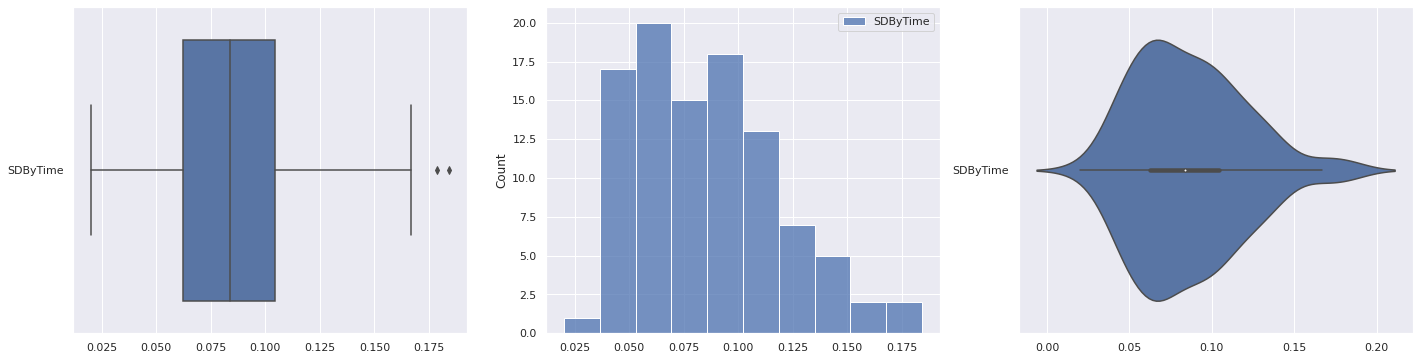

In [ ]:
rating2 = pd.DataFrame(top100restaurants['SDByTime'])
# Set up matplotlib figure with three subplots
f, axes = plt.subplots(1, 3, figsize=(24, 6))

# Plot the basic uni-variate figures for HP
sns.boxplot(data = rating2, orient = "h", ax = axes[0])
sns.histplot(data = rating2, ax = axes[1])
sns.violinplot(data = rating2, orient = "h", ax = axes[2])

As seen in the plots above, the **standard deviations** range from **0.025 to 0.175**, which itself is **quite small**. This thus shows that the time (or hour) of the review posted **does not** bring about a large **difference** in ratings. 



Next, lets take a look at how the year affects the ratings.

The main motivation behind doing this analysis is to find out if the **quality of the restaurants** has drastically **changed over the years**, if they have changed drastically, it would not be wise to feed the 'older' reviews into our Recommender.

1. Slice the 'date' column to get the Year (e.g. 21 or 08) -> 'reviewYear'
2. For each business:
  - Get all reviews
  - Group by 'reviewYear'
  - Get mean for each 'reviewYear' -> 'meanRatingByYear'
  - Get the standard deviation for 'meanRatingByYear' -> **'SDbyYear'**
3. Plot graphs to visualise the data better.

In [ ]:
reviews_timeSeries["reviewYear"] =reviews_timeSeries['date'].apply(lambda x: int(x[0:4]));

In [ ]:
def getSDByYear(reviews_timeSeries,business_id):
  tempDF= reviews_timeSeries.copy()[reviews_timeSeries['business_id'] == str(business_id)]
  tempDF["meanRatingByYear"] = tempDF[["reviewYear","stars"]].groupby('reviewYear')['stars'].transform('mean')
  tempDF = tempDF.drop_duplicates('meanRatingByYear');
  return tempDF['meanRatingByYear'].std()

In [ ]:
top100restaurants['SDByYear'] = top100restaurants['business_id'].apply(lambda x: getSDByYear(reviews_timeSeries,str(x)));

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [ ]:
top100restaurants

,business_id,SDByTime,SDByYear
0,4JNXUYY8wbaaDmk3BPzlWw,0.020134,0.155061
1,RESDUcs7fIiihp38-d6_6g,0.036895,0.128206
2,K7lWdNUhCbcnEvI0NhGewg,0.051088,0.131557
3,DkYS3arLOhA8si5uUEmHOw,0.064789,0.237732
4,f4x1YBxkLrZg652xt2KR5g,0.041582,0.155623
...,...,...,...
95,cJWbbvGmyhFiBpG_5hf5LA,0.102518,0.365008
96,u4sTiCzVeIHZY8OlaL346Q,0.070989,0.201175
97,NCFwm2-TDb-oBQ2medmYDg,0.045582,0.074894
98,kRgAf6j2y1eR0wOFdzFAuw,0.060167,0.125896


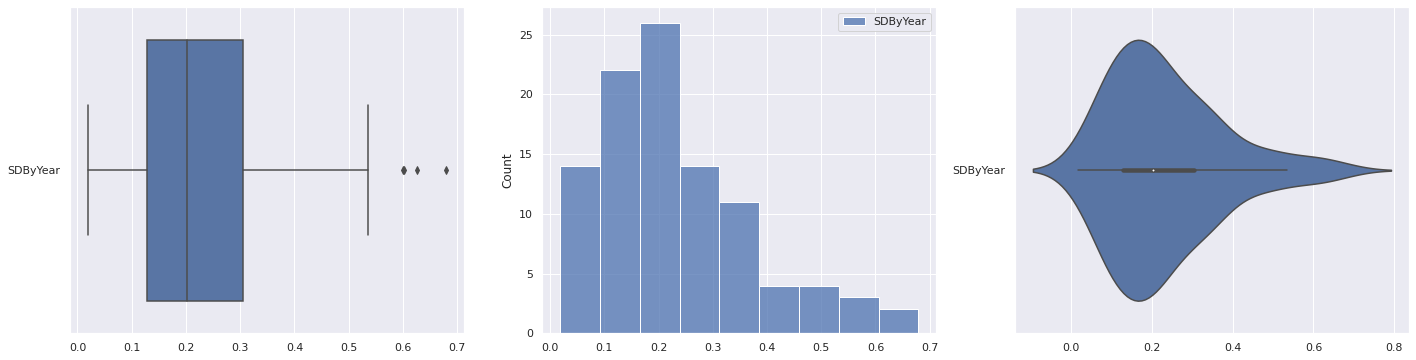

In [ ]:
rating2 = pd.DataFrame(top100restaurants['SDByYear'])
# Set up matplotlib figure with three subplots
f, axes = plt.subplots(1, 3, figsize=(24, 6))

# Plot the basic uni-variate figures for HP
sns.boxplot(data = rating2, orient = "h", ax = axes[0])
sns.histplot(data = rating2, ax = axes[1])
sns.violinplot(data = rating2, orient = "h", ax = axes[2])

As you can see from the plots, there is greater variation here as compared to the previous sub-section on 'time'. However, it is observed that the majority of the standard deviations are **concentrated at the region between 0.1 ~ 0.3**. Hence, we can conclude that over the years, for all the restaurants, quality(as assesed by ratings) **has not significantly changed**. Hence, it is not necessary for us to remove old and 'outdated' reviews.

#### ***Positive and Negative Words***

In this sub-section, we are exploring the **different type of words** used in reviews. We want to explore the **differences between 'postive' and 'negative reviews'**. 

We first start off by **cleaning** the reviews, then visualise using **word-clouds** for both types of reviews.

In [ ]:
import string
from nltk import pos_tag
from nltk.corpus import stopwords
from nltk.tokenize import WhitespaceTokenizer
from nltk.stem import WordNetLemmatizer

from nltk.corpus import wordnet


def get_wordnet_pos(pos_tag):
    if pos_tag.startswith('J'):
        return wordnet.ADJ
    elif pos_tag.startswith('V'):
        return wordnet.VERB
    elif pos_tag.startswith('N'):
        return wordnet.NOUN
    elif pos_tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN
    


def clean_text(text):
    # lower text
    text = text.lower()
    # tokenize text and remove puncutation
    text = [word.strip(string.punctuation) for word in text.split(" ")]
    # remove words that contain numbers
    text = [word for word in text if not any(c.isdigit() for c in word)]
    # remove stop words
    stop = set(stopwords.words('english'))
    text = set(text)
    text = [x for x in text if x not in stop]
    # remove empty tokens
    text = [t for t in text if len(t) > 0]
    # pos tag text
    pos_tags = pos_tag(text)
    # lemmatize text
    text = [WordNetLemmatizer().lemmatize(t[0], get_wordnet_pos(t[1])) for t in pos_tags]
    # remove words with only one letter
    
    uselessWords = set(['great','food','i','s','is','are','he','she','they','but','for','while','there','here','their','but','if',
                    'we','and','it','my','you','me','a','so','wow','excellent','what','well'])
    words = set(nltk.corpus.words.words())
    text = [t for t in text if t not in uselessWords]
    text = [t for t in text if t not in words]
    text = [t for t in text if len(t) > 2]
    # join all
    text = " ".join(text)
    return text

# clean text data

In [ ]:
# MERGE ALL REVIEWS THAT HAVE RATING >= 4.5
def getMergedReview(reviews_df):
  return " ".join(reviews_df[reviews_df['stars'] >= 4.5]['text'].tolist())

In [ ]:
def most_common(text_raw):
  tokenizer = nltk.RegexpTokenizer(r"\w+")
  tokens = tokenizer.tokenize(text_raw)
  freq = nltk.FreqDist(tokens)
  keys = []
  for tup in freq.most_common(100):
    keys.append(tup[0])
  return keys

In [ ]:
cleaned_text = clean_text(getMergedReview(reviews_df))


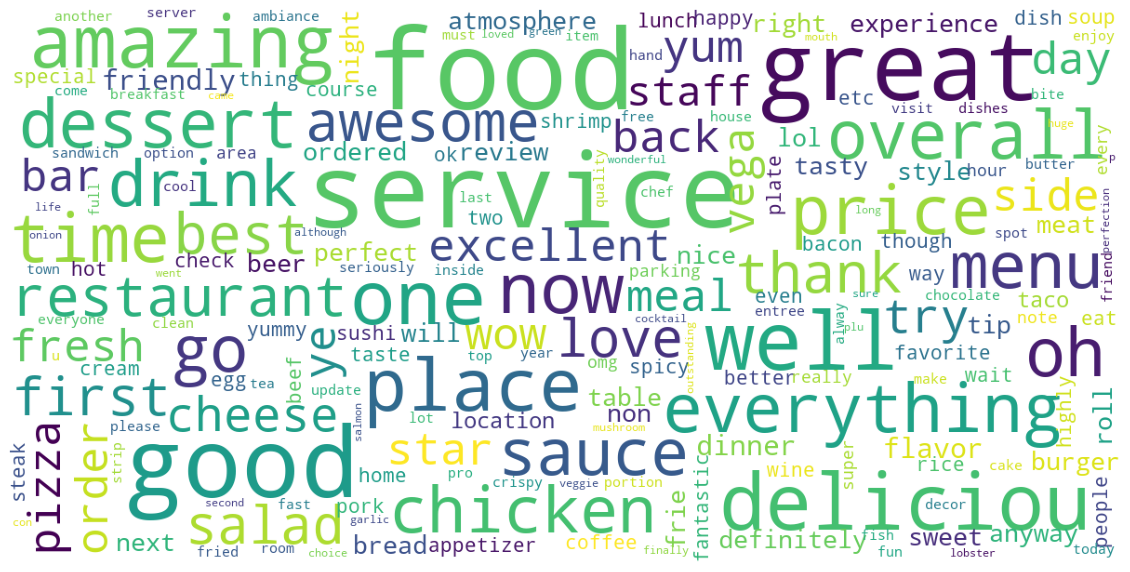

In [ ]:
def show_wordcloud(data, title = None):
    wordcloud = WordCloud(
        background_color = 'white',
        max_words = 200,
        max_font_size = 40, 
        scale = 3,
        random_state = 42
    ).generate(str(data))

    fig = plt.figure(1, figsize = (20, 20))
    plt.axis('off')
    if title: 
        fig.suptitle(title, fontsize = 20)
        fig.subplots_adjust(top = 2.3)

    plt.imshow(wordcloud)
    plt.show()
    
# print wordcloud
show_wordcloud(cleaned_text)

In [ ]:
# MERGE ALL REVIEWS THAT HAVE RATING <= 2
def getMergedReview(reviews_df):
  return " ".join(reviews_df[reviews_df['stars'] <= 2]['text'].tolist())

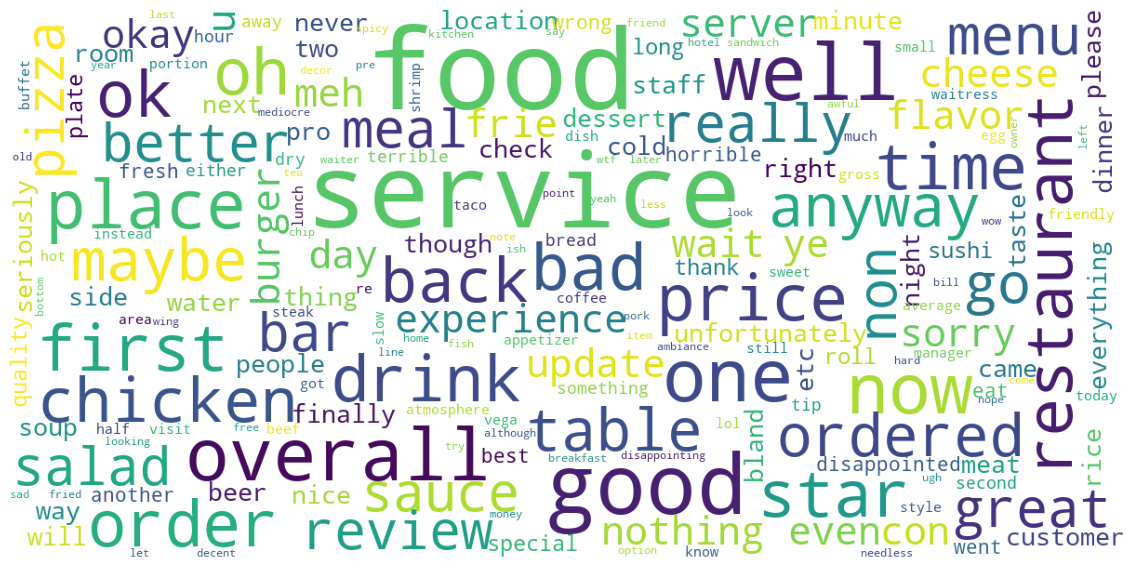

In [ ]:
cleaned_text = clean_text(getMergedReview(reviews_df))
cleaned_text = clean_text(cleaned_text)
show_wordcloud(cleaned_text)

As you can see from the wordclouds, both the positive and negative wordclouds have many words in common such as **service** and **food**, which suggests that is the most important factor when differentiating between 'good' and 'bad' rated restaurants.



Now, we are looking at a restaurant named : **Mon Ami Gab** , with business_id = '4JNXUYY8wbaaDmk3BPzlWw'. It has a total score of 12.7/15 (includes sentiment analysis rating -> refer to Data Pre-Processing to get a better understanding about this score)


In [ ]:
#function to get most commonly used words for each biz id
def most_common (id):
  review_raw = " ".join(review for review in reviews_df['text'].loc[reviews_df['business_id']== id])
  text = clean_text(review_raw)
  return text


In [ ]:
business_text = (most_common('4JNXUYY8wbaaDmk3BPzlWw'))

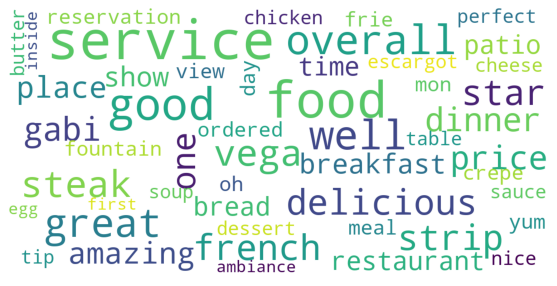

In [ ]:
wordcloud = WordCloud(
        background_color = 'white',
        max_words = 50,
        max_font_size = 40, 
        scale = 3,
        random_state = 42
    ).generate(str(business_text))

fig = plt.figure(1, figsize = (10, 5))
plt.axis('off')

plt.imshow(wordcloud)
plt.show()

Here, we see that this restaurant has these common words in its reviews. **Looks** like it **specialises in french food**, and serves quite delicious food! 

A simple google search on this restaurant confirms this idea:

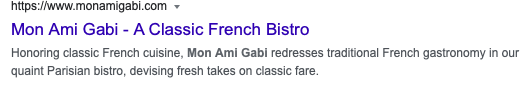

This suggests that our **NLP algorithm** has worked quite well to **sieve** out **important words**!

#### ***Insights***

We want to roughly see what **sort of restaurant** will have **high scores**. To do this, we need **first reduce the number of attributes**. Attributes contain things like XX_True and XX_False, and they actually mean the same thing. We use regex to remove those containing _False.

In [ ]:
restaurants_df = restaurants_df[restaurants_df.columns.drop(list(restaurants_df.filter(regex='False')))]
restaurants_df.columns = restaurants_df.columns.str.replace(' ', '')
copy = restaurants_df.copy().iloc[:,:restaurants_df.shape[1]-6]

Drop duplicate column names

In [ ]:
copy = copy.loc[:,~copy.columns.duplicated()]

In [ ]:
columnSum = copy.sum(axis=0).to_numpy()
columnsDF = pd.DataFrame(copy.columns.to_list())
columnsDF.columns = ["attribute"]
columnsDF['sum']=columnSum

In [ ]:
columnsDF.nsmallest(n=10,columns='sum')

,attribute,sum
760,kosher,0.0
0,&Probates,1.0
3,Accountants,1.0
4,AcneTreatment,1.0
8,Advertising,1.0
11,AirDuctCleaning,1.0
12,AircraftRepairs,1.0
14,AirportShuttles,1.0
16,Airsoft,1.0
17,AlternativeMedicine,1.0


We know that some restaurants have weird attributes, such as Accountants. It is because the restaurant is located near or in an accounting firm, so it will have some of these attributes attached. These are irrelevant attributes and only exist for one or more restaurants out of so many restaurants. We will drop those attributes with low number of '1's. After testing, attributes with fewer than 50 '1's will be dropped, since they are just irelevant attributes.

In [ ]:
columnsDF = columnsDF.loc[columnsDF['sum']>50]

Then we drop a few more that are not really restaurants-related, and some repeated columns

In [ ]:
columnsDF=columnsDF.loc[columnsDF['attribute'] != 'InternetCafes']
columnsDF=columnsDF.loc[columnsDF['attribute'] != 'Party&EventPlanning']
columnsDF=columnsDF.loc[columnsDF['attribute'] != 'Education']
columnsDF=columnsDF.loc[columnsDF['attribute'] != 'Shopping']
columnsDF=columnsDF.loc[columnsDF['attribute'] != 'PoolHalls']
columnsDF=columnsDF.loc[columnsDF['attribute'] != 'ShoppingCenters']
columnsDF=columnsDF.loc[columnsDF['attribute'] != 'Arts&Entertainment']
columnsDF=columnsDF.loc[columnsDF['attribute'] != 'Beauty&Spas']
columnsDF=columnsDF.loc[columnsDF['attribute'] != 'Bed&Breakfast']
columnsDF=columnsDF.loc[columnsDF['attribute'] != 'Automotive']
columnsDF=columnsDF.loc[columnsDF['attribute'] != 'Arcades']
columnsDF=columnsDF.loc[columnsDF['attribute'] != 'Bowling']
columnsDF=columnsDF.loc[columnsDF['attribute'] != 'NoiseLevel_None']
columnsDF=columnsDF.loc[columnsDF['attribute'] != "NoiseLevel_'very_loud'"]
columnsDF=columnsDF.loc[columnsDF['attribute'] != "NoiseLevel_'quiet'"]
columnsDF=columnsDF.loc[columnsDF['attribute'] != "NoiseLevel_'average'"]
columnsDF=columnsDF.loc[columnsDF['attribute'] != "NoiseLevel_'loud'"]

In [ ]:
new_attr_list = columnsDF['attribute'].tolist()

In [ ]:
copy = copy.loc[:, copy.columns.isin(new_attr_list)]

In [ ]:
columnSum = copy.sum(axis=0).to_numpy()

In [ ]:
starsList = restaurants_df['stars'].to_numpy()

In [ ]:
matrix = np.matmul(starsList,copy.to_numpy())
score = np.divide(matrix,columnSum)

In [ ]:
columnsDF=pd.DataFrame()
columnsDF['attribute']=copy.columns.tolist()
columnsDF['sum']=columnSum
columnsDF['score'] = score

In [ ]:
copy['stars']=restaurants_df['stars']
copy['city']=restaurants_df['city']
copy['business_id']=restaurants_df['business_id']
copy['name']=restaurants_df['name']
copy['totalScore']=restaurants_df['totalScore']
copy['averageScore']=restaurants_df['averageScore']

In [ ]:
copy.head()

,AcaiBowls,ActiveLife,Afghan,African,American(New),American(Traditional),Arabian,AsianFusion,Bagels,Bakeries,Barbeque,Bars,Beer,BeerBar,BeerGardens,Bistros,Brasseries,Brazilian,Breakfast&Brunch,Breweries,Brewpubs,British,BubbleTea,Buffets,Burgers,Butcher,Cafes,Cajun/Creole,Canadian(New),Cantonese,Caribbean,Casinos,Caterers,CheeseShops,Cheesesteaks,ChickenShop,ChickenWings,Chinese,Chocolatiers&Shops,CocktailBars,...,DriveThru_True,BusinessAcceptsBitcoin_True,GoodForDancing_True,Smoking_u'no',Smoking_u'outdoor',Smoking_u'yes',BYOBCorkage_'no',BYOBCorkage_'yes_corkage',BYOBCorkage_'yes_free',CoatCheck_True,garage_True,street_True,validated_True,lot_True,valet_True,touristy_True,hipster_True,romantic_True,intimate_True,trendy_True,upscale_True,classy_True,casual_True,divey_True,dessert_True,latenight_True,lunch_True,dinner_True,brunch_True,breakfast_True,dj_True,background_music_True,jukebox_True,live_True,stars,city,business_id,name,totalScore,averageScore
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4.5,Champaign,pQeaRpvuhoEqudo3uymHIQ,The Empanadas House,14.341500,9.841500
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3.0,Charlotte,CsLQLiRoafpJPJSkNX2h5Q,Middle East Deli,8.964250,5.964250
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4.5,Thornhill,lu7vtrp_bE9PnxWfA8g4Pg,Banzai Sushi,8.858000,4.358000
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3.0,Richmond Hill,9sRGfSVEfLhN_km60YruTA,Apadana Restaurant,10.312500,7.312500
4,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4.0,Phoenix,vjTVxnsQEZ34XjYNS-XUpA,Wetzel's Pretzels,13.275125,9.275125


In [ ]:
restaurants_df = copy

In [ ]:
columnsDF.nlargest(n=10,columns='score')

,attribute,sum,score
143,ShavedIce,59.0,4.279661
227,BYOB_True,80.0,4.231250
152,StreetVendors,208.0,4.153846
127,Patisserie/CakeShop,95.0,4.147368
75,Gelato,59.0,4.135593
71,FoodTrucks,506.0,4.109684
41,CoffeeRoasteries,88.0,4.085227
57,Ethiopian,60.0,4.075000
109,Live/RawFood,65.0,4.069231
85,Himalayan/Nepalese,51.0,4.058824


This shows that what are the likely popular attributes among good restaurants. However, we realise that the number of restaurant having such attributes are small, and this might skew the mean upwards. What if we check based on 'sum'?

In [ ]:
columnsDF.loc[columnsDF['sum']>1000].nlargest(n=10,columns='score')

,attribute,sum,score
245,hipster_True,1014.0,3.952663
214,DogsAllowed_True,1602.0,3.952559
164,Vegetarian,1042.0,3.868522
248,trendy_True,2480.0,3.839315
226,WheelchairAccessible_True,9663.0,3.820553
26,Cafes,2644.0,3.816377
51,Desserts,1581.0,3.799810
115,Mediterranean,1390.0,3.793885
149,SpecialtyFood,1792.0,3.793248
9,Bakeries,1556.0,3.792738


Ok, that still does not give us much, but we can infer that maybe facilities (such as having accessibility to wheelchair) and types of restaurants might influence score.
Also, users seem to prefer hipster-styled restaurants?

In [ ]:
columnsDF.nsmallest(n=10,columns='score')

,attribute,sum,score
229,DriveThru_True,999.0,2.660160
63,FastFood,5437.0,2.821133
160,Tex-Mex,624.0,2.940705
189,NoiseLevel_u'very_loud',1043.0,2.984660
35,ChickenShop,517.0,2.985493
36,ChickenWings,2084.0,2.993042
24,Burgers,4413.0,3.002606
155,Tacos,721.0,3.032594
23,Buffets,653.0,3.142420
221,WiFi_None,85.0,3.200000


The 'bad' restaurant part is clearer: environment - being noisy, and the type (fast food type of restaurant seem to have higher possibilities of having bad reviews)
Users seem to dislike texas/mexico food as well, but that's probably due to the low number of restaurants in this sample.

In [ ]:
columnsDF = columnsDF.reset_index()

In [ ]:
columnsDF.iloc[186:190]

,index,attribute,sum,score
186,186,NoiseLevel_u'average',22629.0,3.513478
187,187,NoiseLevel_u'loud',2861.0,3.224747
188,188,NoiseLevel_u'quiet',7596.0,3.554371
189,189,NoiseLevel_u'very_loud',1043.0,2.984660


## **Recommender**

#### **User-Restaurant Matrix (Not using)**

**Update**: This is the first recommender we built, and we have decided not to use this, we have explained our reasons in this sub-section's conclusion.

This is how we planned to execute this:
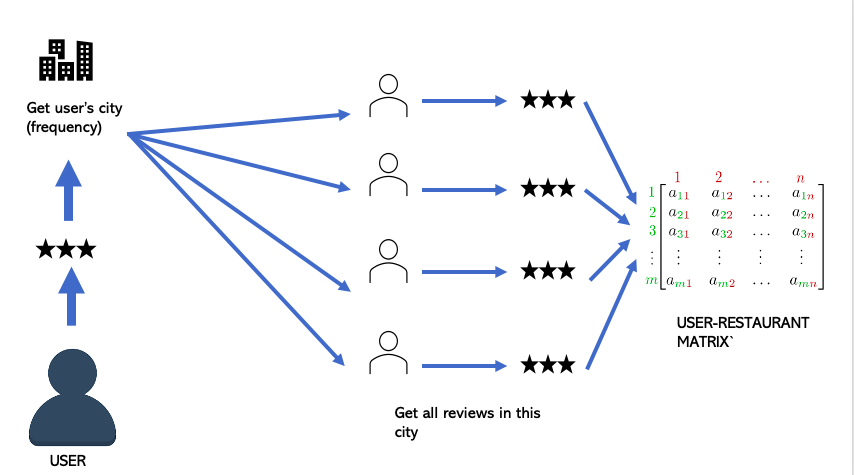
1. Choose an arbitrary user
2. Get all the reviews written by that user.
3. Assign the user a 'city' based on the reviews (highest frequency)
4. Get all the reviews written in this city.
5. Create the user-restaurant matrix (based on stars).
6. Get reviews of the user and his friends and filter by 'city' and recommend from the matrix, by using some similarity index.



In [ ]:
# Returns the city of an arbitrary user
def getCityOfUser(userVisited,restaurantDF):

  cities = {}
  
  for restaurant in userVisited:

    city = restaurantDF[restaurantDF['business_id'] == str(restaurant)]['city'].reset_index(drop=True)[0]

    if city in cities.keys():
      cities[city] += 1
    else:
      cities.update({str(city):1})


    max_city = max(cities, key=cities.get)
  
  return max_city

In [ ]:
# Returns a List of restaurants that the user and his friends have visited
def getUserFriendsRestaurants(userID,reviews):

  try:
    userFriendsList = reviews[reviews['user_id']== str(userID)]["realFriends"][0].reset_index(drop=True)

  except:
    userFriendsList = []

  friendsVisitDF = pd.DataFrame()
  userVisitedList = []
  friendsVisitedList = []
  # print(str(len(userFriendsList)))
  # i = 0

  # get the restaurants visited by the user

  userVisitedDF = reviews[reviews["user_id"] == str(userID)].reset_index(drop=True)
  if userVisitedDF.empty == False:
    userVisitedDF.drop_duplicates('business_id',inplace=True)
    userVisitedList = userVisitedDF['business_id'].tolist()
  
  for friend in userFriendsList:
    # print(i)
    friendsVisitDF = pd.concat([friendsVisitDF, reviews[reviews["user_id"] == str(friend)]]).reset_index(drop=True)
    # i+=1

  if friendsVisitDF.empty == False:
    friendsVisitDF.drop_duplicates('business_id',inplace=True)
    friendsVisitedList = friendsVisitDF['business_id'].tolist()


  return set(userVisitedList),set(friendsVisitedList)

In [ ]:
# Returns a DataFrame containing reviews written by the arbitrary user and his friends
def getUserFriendDataFrame(userID,reviews):
  userVisitDF = reviews[reviews['user_id']== str(userID)].reset_index(drop=True)

  try:
    userFriendsList = userVisitDF["realFriends"][0]
  except KeyError:
    userFriendsList = []
  friendsVisitDF = pd.DataFrame()


  # get the restaurants visited by the user
  userVisitedDF = reviews[reviews["user_id"] == str(userID)]
  # userVisitedDF.drop_duplicates('business_id',inplace=True)
  
  for friend in userFriendsList:
    friendsVisitDF = pd.concat([friendsVisitDF, reviews[reviews["user_id"] == str(friend)]])

  return pd.concat([userVisitDF,friendsVisitDF]).reset_index(drop=True)

In [ ]:
# Returns a DataFrame containing all restaurants in the city
def getCityRestaurantData(restaurants,city):
  return pd.DataFrame(restaurants[restaurants['city']== str(city)]).reset_index(drop=True)

In [ ]:
# Returns a DataFrame that contains all the review in the city
def getReviewsInCity(restauarntsDF,reviewsDF,city):
  city_restaurants = getCityRestaurantData(restaurants_df,city)
  restaurants_id_df = pd.DataFrame(city_restaurants[['business_id']])
  reviews_incity_df = pd.merge(
    left = reviews_df,
    right = restaurants_id_df,
   how ='inner',
    left_on ='business_id',
    right_on ='business_id')
  
  return reviews_incity_df.reset_index(drop=True)

In [ ]:
# Create the user-restaurant matrix basesd on stars,use SVD and get the correlation matrix.
def getCorrelationMatrix(restaurants_in_city,reviews_in_city):

  reviewsDF = reviews_in_city[['user_id','business_id','stars']]
  restaurantsDF = restaurants_in_city[['business_id','name']]


  combined_data = pd.merge(reviewsDF,restaurantsDF,on='business_id').reset_index(drop=True)

  rating_crosstab = combined_data.pivot_table(values='stars',index='user_id',columns='business_id',fill_value = 0)
  X = rating_crosstab.values.T

  SVD = TruncatedSVD(n_components=12,random_state=10)
  result_matrix = SVD.fit_transform(X)
  corr_matrix = np.corrcoef(result_matrix)


  return corr_matrix,rating_crosstab

In [ ]:
# Returns DataFrame that has a list of recommendation for each row.
def getCompleteRecommendation(userID,reviewsDF,restaurantsDF):

  userRestaurant,friendsRestaurant = getUserFriendsRestaurants(userID,reviewsDF) 
  city = getCityOfUser(userRestaurant,restaurantsDF)
  print(city)
  city_restaurant_data = getCityRestaurantData(restaurantsDF,city)
  city_review_data = getReviewsInCity(restaurantsDF,reviewsDF,city)
  userFriendsDF = getUserFriendDataFrame(userID,reviewsDF)
  userFriendsDF = pd.merge(left = userFriendsDF,right = restaurantsDF,how ='inner',left_on ='business_id',right_on ='business_id')
  userFriendsDF.reset_index(drop=True)


  corr_matrix,rating_crosstab = getCorrelationMatrix(city_restaurant_data,city_review_data)
  restaurant_ids = rating_crosstab.columns
  restaurant_list = list(restaurant_ids)

  userFriendsDF["recommendations"] = userFriendsDF.apply(
      lambda x : 
      
      list(restaurant_ids[ (corr_matrix[restaurant_list.index(str(x["business_id"]))]  < 0.99) &
                          (corr_matrix[restaurant_list.index(str(x["business_id"]))]  > 0.89) ])
      if x["city"] == str(city)  else [],axis =1)
  
  return userFriendsDF,city

In [ ]:
id = reviews_df['user_id'][0]
print(id)


ZJ6sj1IjdwmPPL_ZxmRKgw


In [ ]:
final_df,city = getCompleteRecommendation(id,reviews_df,restaurants_df)
final_df = final_df[final_df['city'] == str(city)]

Charlotte


In [ ]:
recommendationsList = final_df['recommendations'].tolist()

In [ ]:
def iterFlatten(root):
    if isinstance(root, (list, tuple)):
        for element in root:
            for e in iterFlatten(element):
                yield e
    else:
        yield root


recommendationsList = list(iterFlatten(recommendationsList))
recommendationsList = list( dict.fromkeys(recommendationsList) )
print("RecommendationList: ")
print(recommendationsList)

RecommendationList: 
['VdyTesw5gfEOlMPs7pcH0g', 'XHcuFkQaZltjjZmHRR9b-w', 'gG2S0HPvInQDUKdCJmpfqA', 'yR_mPDR9kNWmXADWk6-TLw', '4vDffQ7eSQ7n39cyroOSKQ', '8nmjvYX4N67cxOsGfbEgjg', 'NsWc7zJG5PN_frYqMOa9mQ', 'xEIqG7Rq8ydAT9LxCVBOOg', 'zxsktAMsVBKj2PvvCV11UQ', 'HsS34pXt9SAmaRa2aByNpw', 'SCipkpUXrKGM0hJiRIDBHg', '-5L8zOxibac-vBrsYtxXbQ', '10tJuB_YkVQWuk4PtoI7iA', '13-n6Gm0AK0QK28iatttWQ', '1H-iDMc4d3IeYvOflXTOXw', '1WtUgLhdBdQ39aBvEUbsnw', '1czIVv2iyOHc3WMgtUWXCQ', '1p7CaMTJBO1VuvpogOvrFA', '5Day_lf10DyvKk9tmKqjRA', '6kq9oLduJAYkb2WjAb36KA', '83hb_woC2JEOA1ZEIZKJlA', '9k-q8w2MsVuc1KcpwKZ2Hw', 'AAekuF59Qr84gAh18o9njg', 'CrPm7Rby304RmpFgmIBdUQ', 'CxsN79g8rZoouLwZvr_FVg', 'Daasejc2-RV-MxEKpPjXtA', 'DtNxNpyxy2ctvxpg-LCS_w', 'E0TK141YMBP0LBknhVKEqw', 'EvWGuX0eqKcZvLRgtIFHZg', 'HDv-KchmLSlRr5MXxRkNqQ', 'ICUCAzUZFiWkYs7iCtNCQg', 'IE0QRqaUSW51RmShZ9dX1Q', 'IqH-J1D0HIP9wyJs2q_uGQ', 'JogUSDKa1xyG3lLEmD4Xjg', 'KEGLWeFAWXvo0W2LnujhtQ', 'LQI8R7yYXmWzWKd7wLCf2Q', 'QH2OSulslnQ7Yn8Xs81SPg', 'QReGruZEFxovIm9

Upon **studying this model carefully**, we realised there are **some flaws** that we overlooked.

1. **Minor issue**: We decided our unique selling point (USP) of our recommender to be that where the recommendations are based on both the user reviews and his friends reviews. However, here we feel that this case is  addressed poorly here as the recommender solely r**ecommends based on individual restaurants (one row at a time)**, rather than finding similarities to a group of restaurants. 

2. **Major issue**: We are not making use of reviews written by friends outside the city of the user. We have observed that in the dataset, the number of friends outside the city usually outweigh the number of friends in the city. So, **disregarding the friends reviews outside the city does not make any sense**. 


Hence, this is the reason we chose to recommend restaurants not based on the user-restaurant matrix but **rather use the restraunts attributes to create a restaurant-restaurant matrix**

#### **Restaurant-Restaurant Matrix (FINAL)**


Since our premise is that friends have similar tastes, as mentioned in the previous sub-section, it is crucial to take into account a friend's review even though that restaurant is not situated in the User's City. In addtion in our EDA subsection we found out that the city the restaurant is located in, has no correlation with ratings.

<br>This is how we plan to implement: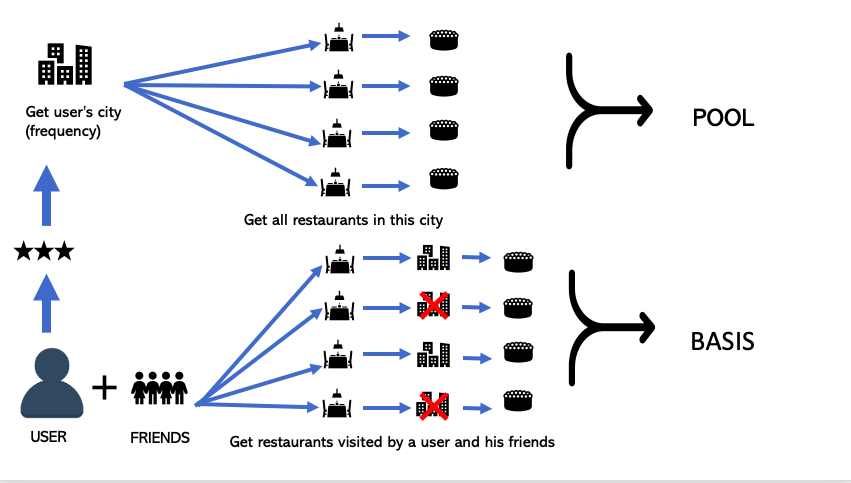



1. For an **arbitrary user**, get all the restaurants he has reviewed. **Assign the user a 'city'** based on the reviews he has written (i.e. get the city with the highest frequency).
2. Get all the **restaurants** that have been reviewed by the **user's friends**
3. Get all the **restaurants that exists in the city** (obtained from step 1). This would be known as the **'pool'**
4. Concatenate **resulting datasets from steps 1 and 2**. This would be known as the **'basis'**.
5. By using attributes from each restaurant, we aim to recommend restaurants from the 'pool' by **comparing the similarities** of attributes between the **'basis' and the 'pool'**. 


Since, we are comparing the attributes of the restaurants to see how similar they are, it does not matter if some restaurants in the 'basis' are not situated in the city itself.





##### ***Using Principal Component Analysis (PCA) for dimension reduction***.

In [ ]:
restaurants_df.shape

(58984, 269)

We do suspect that some columns might be a linear combination of each other. They are just opposite of each other, but it is impossible to find each pair and remove one of them. PCA will help with this. So, let's do **PCA** to see how many dimensions are required to **get an explained variance of > 95%**

In [ ]:
PCA_df = restaurants_df.copy()
PCA_df = PCA_df.drop(columns='name')
PCA_df = PCA_df.drop(columns='city')
PCA_df = PCA_df.drop(columns='business_id')
PCA_df = PCA_df.drop(columns = 'stars')
PCA_df = PCA_df.drop(columns = 'averageScore')
PCA_df = PCA_df.drop(columns = 'totalScore')

In [ ]:
PCA_cp = PCA_df.copy()

In [ ]:
#no need to run
n = 0
variance = 0
while variance<0.95:
  n= n + 100
  pca = PCA (n_components=n)
  pca.fit(PCA_cp)
  variance = np.sum(pca.explained_variance_ratio_)
print(n)

200


In [ ]:
#no need to run
n = 100
variance = 0
while variance<0.95:
  n= n + 10
  pca = PCA (n_components=n)
  pca.fit(PCA_cp)
  variance = np.sum(pca.explained_variance_ratio_)
print(n)

120


In [ ]:
#no need to run
n = 110
variance = 0
while variance<0.95:
  n= n + 1
  pca = PCA (n_components=n)
  pca.fit(PCA_cp)
  variance = np.sum(pca.explained_variance_ratio_)
print(n)

114


In [ ]:
#no need to run
pca = PCA(n_components=114)
pca.fit(PCA_cp)
variance = np.sum(pca.explained_variance_ratio_)
print(variance)

0.9503061694823566


From here, we can **deduce that 114** components captures about **95% of the explained variance**. 

In [ ]:
pca = PCA (n_components=114)
PCA_result = pca.fit_transform(PCA_df)
principalDf = pd.DataFrame(data = PCA_result)
del PCA_df
del PCA_result
principalDf['totalScore']=restaurants_df['totalScore']
principalDf['name']=restaurants_df['name']
principalDf['business_id']=restaurants_df['business_id']
principalDf['city']=restaurants_df['city']
principalDf['stars']=restaurants_df['stars']

In [ ]:
principalDf.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,totalScore,name,business_id,city,stars
0,-1.250932,-0.454795,-0.067410,0.514803,0.002618,0.571987,-0.269071,0.160047,0.928948,-0.205800,0.054472,-0.080144,0.090776,-0.437769,0.693453,0.009480,0.938401,0.179481,-0.514710,0.105324,-0.070280,0.303166,0.261968,0.005391,-0.336550,0.255216,-0.144426,-0.493740,0.230746,0.389169,0.096970,-0.381119,-0.111496,0.233034,-0.226317,0.541063,0.047200,-0.152603,-0.128396,0.255864,...,-0.024462,-0.021432,-0.005869,0.002169,0.108065,-0.040366,-0.065197,-0.081861,0.041037,0.001784,0.067010,0.005165,-0.045083,-0.058614,-0.000013,-0.035594,-0.040749,-0.034489,-0.033078,0.041798,0.028723,-0.046792,0.009035,-0.022938,-0.029301,0.005800,-0.098298,0.035141,-0.129961,0.048110,-0.091212,-0.160250,-0.042752,0.282557,0.082058,14.341500,The Empanadas House,pQeaRpvuhoEqudo3uymHIQ,Champaign,4.5
1,-1.093258,-0.410032,-0.389996,0.257853,-0.509821,0.221805,-0.004077,-0.193865,-0.067124,0.382878,-0.175913,0.223929,0.875653,-0.228775,0.214337,0.331598,0.016283,0.055577,0.178569,0.192044,-0.255785,-0.289449,-0.015879,-0.073583,-0.040987,0.008931,-0.084954,-0.057877,-0.005283,-0.223186,0.186486,0.110616,0.040479,-0.096689,-0.141400,-0.034997,-0.006817,0.027554,-0.017983,-0.004251,...,0.135624,0.178064,-0.043252,-0.018075,-0.129776,0.020056,0.074138,0.005475,-0.186092,0.076790,-0.323800,-0.309418,0.521922,-0.260690,0.149222,-0.151213,0.060906,-0.052807,-0.036477,0.007418,-0.028810,-0.071877,-0.021426,0.021993,0.002787,0.022265,-0.009259,0.140686,0.046130,0.035139,0.081215,0.152947,0.083771,-0.117788,0.052831,8.964250,Middle East Deli,CsLQLiRoafpJPJSkNX2h5Q,Charlotte,3.0
2,-1.501898,-0.187775,-0.169272,-0.280686,0.485760,0.242628,0.004432,0.179835,0.363726,-0.094409,-0.299842,-0.284987,0.371060,0.090391,-0.269030,-0.603062,-0.350983,-0.321991,0.257948,-0.192554,-0.137613,0.159774,-0.425578,-0.255370,-0.087785,-0.063551,0.444145,0.013543,-0.371789,0.286927,-0.228081,0.140467,0.180049,-0.023656,0.133324,-0.313174,0.098249,-0.160636,0.410513,0.140076,...,0.042281,-0.094527,0.045956,-0.015050,0.122307,-0.019555,-0.031472,-0.105966,-0.004442,-0.068327,0.015328,0.015166,0.022876,-0.027991,-0.055364,0.050808,-0.012769,0.026715,0.066836,0.070700,-0.009757,0.103780,0.100378,-0.009645,-0.023503,0.002449,0.021303,-0.054577,0.011039,-0.026335,0.055560,-0.120394,-0.061808,-0.045689,0.017060,8.858000,Banzai Sushi,lu7vtrp_bE9PnxWfA8g4Pg,Thornhill,4.5
3,-0.040746,1.173532,0.321869,0.389966,1.257900,0.539167,-0.913634,1.074642,-0.043976,0.140603,-0.282074,-0.258713,-0.146912,-0.334936,-0.690861,-0.205453,0.518264,-0.042417,-0.093621,0.764080,-0.053256,0.668546,-0.119691,-0.383064,0.304994,-0.074665,0.305845,-0.111148,0.138002,-0.219429,-0.065936,-0.253575,-0.017824,0.109255,-0.130987,-0.142716,0.070860,0.085689,0.137365,-0.011984,...,0.139046,0.033482,-0.017042,-0.064325,-0.032227,0.034954,-0.021201,-0.042365,-0.196261,0.063750,-0.324494,-0.334407,0.477317,-0.308211,0.121138,-0.175777,0.076572,-0.057236,0.031172,0.059350,-0.041224,0.079149,0.096183,-0.005348,-0.081256,-0.021003,-0.055706,0.078093,0.099423,0.041181,0.076780,-0.097285,0.023119,-0.054522,-0.007017,10.312500,Apadana Restaurant,9sRGfSVEfLhN_km60YruTA,Richmond Hill,3.0
4,-0.697602,-1.105009,-0.334087,0.588511,-0.281934,0.215621,0.065502,-0.357284,0.018566,0.474929,0.054844,0.574875,0.193117,0.176929,0.339684,0.297000,-0.612135,-0.677298,0.249546,-0.256900,-0.168505,-0.198893,-0.232435,-0.236335,0.281411,0.021897,0.242810,0.070334,-0.032598,-0.014091,-0.048475,0.065578,0.298190,-0.096795,0.184336,-0.131922,-0.135205,-0.311080,0.068604,0.122222,...,0.066951,-0.062851,0.041295,0.085416,0.006060,0.000162,0.000503,-0.067393,-0.015345,-0.060047,-0.020859,-0.024767,0.026026,0.048819,-0.087021,0.124852,0.025057,0.050695,0.069372,0.003265,-0.001938,0.0

##### **Important Functions needed for Recommendation Model**

In [ ]:
# Returns a list of restaurants an arbitrary user has reviewed
def user_been_to(id,review_data):
  '''first arg is user id, second arg is the review dataframe, returns array of biz id'''
  been_to = []
  for biz in review_data.loc[review_data['user_id']== id]['business_id']:
    been_to.append(biz)
  from collections import Counter
  been_to_count = dict(Counter(been_to))
  been_to = list(been_to_count.keys()) #remove repeated values

  return been_to

In [ ]:
# Returns a list of friends of an arbitrary user
def getFriendList(userID,reviews):
  userVisitDF = reviews[reviews['user_id']== str(userID)]

  try:
    userFriendsList = userVisitDF["realFriends"][0]
  except KeyError:
    userFriendsList = []
  return userFriendsList

In [ ]:
# Returns 2 dataframes: ref_biz and test_biz. ref_biz is the restaurants reviewed by an arbitrary user and his friends.
# test_biz contains 25% of restaurants reviewed by an user in a city, that is not included to help generate the recommendation.

def getUserFriendDataFrame(userID,friendList,reviews,restaurants):
  biz_list = []
  biz_list_test = []
  ref_biz = pd.DataFrame()
  test_biz = pd.DataFrame()
  
  user_list = user_been_to(userID,reviews)
  user_city_list = []
  user_non_city_list =[]
  city = getCityOfUser(user_list,restaurants)
  city_restaurant_df = restaurants[restaurants['city'] == str(city)]
  city_restaurant_df = city_restaurant_df[city_restaurant_df['stars'] > 4]
  city_restaurants_list = set(city_restaurant_df['business_id'].tolist())

  print("Length of user list:", len(user_list))

  for biz in user_list:
    if (biz in city_restaurants_list) :
      if reviews[((reviews['user_id']== userID) & (reviews['business_id']== biz) )]['stars'].mean() >= 4:
        user_city_list.append(biz)
    else:
      user_non_city_list.append(biz)

  else:
      user_non_city_list.append(biz)
  
  print("length of user_city_list",len(user_city_list))
  testAfterIndex = int(len(user_city_list)-1)
  print("index: ",testAfterIndex)

  if testAfterIndex != 0:
    biz_list_test = user_city_list[testAfterIndex:]
    biz_list = user_city_list[:testAfterIndex] + user_non_city_list
  else:
    biz_list = user_list

  print('biz list',len(biz_list))
  print('biz list test',len(biz_list_test))

  
  for name in friendList:
    biz_list = biz_list + user_been_to(name,reviews)

  for biz in biz_list:
    df = restaurants.loc[restaurants['business_id']== biz]
    ref_biz=pd.concat([ref_biz,df])
  ref_biz = ref_biz.drop_duplicates(subset=['business_id']).reset_index()

  for bizTest in biz_list_test:
    df = restaurants.loc[restaurants['business_id']== bizTest]
    test_biz=pd.concat([test_biz,df])
  test_biz = test_biz.drop_duplicates(subset=['business_id']).reset_index()
  
  print(ref_biz.shape)
  print(test_biz.shape)

  return ref_biz,test_biz

In [ ]:
# returns lists of restaurants reviewed by an artbitrary user and his friends
def getUserFriendsRestaurants(userID,reviews):

  try:
    userFriendsList = reviews[reviews['user_id']== str(userID)]["realFriends"][0].reset_index(drop=True)

  except:
    userFriendsList = []

  friendsVisitDF = pd.DataFrame()
  userVisitedList = []
  friendsVisitedList = []
  # print(str(len(userFriendsList)))
  # i = 0

  # get the restaurants visited by the user

  userVisitedDF = reviews[reviews["user_id"] == str(userID)].reset_index(drop=True)
  if userVisitedDF.empty == False:
    userVisitedDF.drop_duplicates('business_id',inplace=True)
    userVisitedList = userVisitedDF['business_id'].tolist()
  
  for friend in userFriendsList:
    # print(i)
    friendsVisitDF = pd.concat([friendsVisitDF, reviews[reviews["user_id"] == str(friend)]]).reset_index(drop=True)
    # i+=1

  if friendsVisitDF.empty == False:
    friendsVisitDF.drop_duplicates('business_id',inplace=True)
    friendsVisitedList = friendsVisitDF['business_id'].tolist()


  return set(userVisitedList) ,set(friendsVisitedList)

In [ ]:
# returns the city of an arbitrary user, given the list of restaurants he has reviewed. (Returns the city with the max frequency)
def getCityOfUser(userVisited,restaurantDF):

  cities = {}
  max_city = None
  
  for restaurant in userVisited:

    city_df = restaurantDF[restaurantDF['business_id'] == str(restaurant)].reset_index(drop=True)
    if city_df.empty == False:
      city = city_df['city'][0]
    else:
      continue;

    if city in cities.keys():
      cities[city] += 1
    else:
      cities.update({str(city):1})


    max_city = max(cities, key=cities.get)
  
  return max_city

In [ ]:
# returns a DataFrame that includes restaurants in an arbitrary city
def getCityRestaurantData(restaurants,city):
  return pd.DataFrame(restaurants[restaurants['city']== str(city)]).reset_index(drop=True)

In [ ]:
# returns a DataFrame that includes reviews from an arbitrary city
def getReviewsInCity(restauarntsDF,reviewsDF,city):
  city_restaurants = getCityRestaurantData(restaurants_df,city)
  restaurants_id_df = pd.DataFrame(city_restaurants[['business_id']])
  reviews_incity_df = pd.merge(
    left = reviews_df,
    right = restaurants_id_df,
   how ='inner',
    left_on ='business_id',
    right_on ='business_id')
  
  return reviews_incity_df.reset_index(drop=True)


In [ ]:
def getrating(id,reviews_df,rec_basis):
  friend_df = reviews_df.loc[reviews_df['user_id']==id]
  friend_df = friend_df.drop_duplicates(subset='user_id')
  friend_list = list(friend_df['realFriends'])[0]
  friend_list.append(id)
  rating_df = reviews_df[reviews_df.user_id.isin(friend_list)]
  rating_df = rating_df[rating_df.business_id.isin(rec_basis['business_id'].to_list())]
  rating_df = rating_df[['business_id','stars']]
  rating_df = rating_df.groupby('business_id').mean().reset_index()
  ratingList = []
  for biz_id in rec_basis['business_id']:
    ratingList.append(rating_df[rating_df['business_id']== biz_id]['stars'].item())
  return ratingList

##### ***Assign recommendation score and test for model accuracy***

So How do we assign scores to each of the restaurant from the recommendation pool? The following function is helpful:
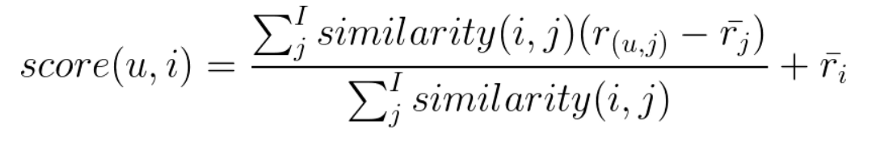

In this function, we generate a score for item i - to see if it should be recommended to this user. First, we compare the similarity between item i and j, with j being the item that the user or their friends have reviewed. We define the similarity function in terms of cosine similarity, ranging from 0 and 1. It is defined based on the attributes and categories from business_data (such as the type of food provided, the noise level of the restaurant, etc...). If item i and j are completely different (meaning similarity(i,j) will give a 0), the relevant score of j will not be used in calculating the score for i. This makes sense, because if two items are completely different, j would not be of use in helping to indicate the score for i.

The (r(u,j)-rj) term is just a measure of how the user rated item j. r(u,j) will be the user's actual review score given to item j, whereas rj is the average score of item j received from all its customers. This is to see how the user rated j compared to the average rating and the capture the actual 'taste' of the user. If this term gives a negative number, it means that to this user personally, they dislike the restaurant compared to the average sentiment. If the term gives a positive number, it means that the user perfers this restaurant more than average.
Finally, the term ri is the average score of restaurant i. It is modified by the previous term to reflect user's 'predicted taste'. Combining them all together, we have a score(u,i) predicted for an item i. The higher the score, the more likely the user will rate this item highly. We will recommend the items of higher score to this user.

But before we do anything, we need to change the friends in reviews_df into a list (since it is read as a string for csv)



In [ ]:
reviews_df = pd.read_csv('/content/drive/MyDrive/CZ1016 Mini Project/restaurant_review.csv')

In [ ]:
reviews_df.head()

,Unnamed: 0,review_id,user_id,business_id,stars,useful_x,funny_x,cool_x,text,date,name,review_count,yelping_since,useful_y,funny_y,cool_y,elite,friends,fans,average_stars,compliment_hot,compliment_more,compliment_profile,compliment_cute,compliment_list,compliment_note,compliment_plain,compliment_cool,compliment_funny,compliment_writer,compliment_photos
0,0,Oyfn6OGRXwN9QtVyDj1v9Q,ZJ6sj1IjdwmPPL_ZxmRKgw,OQvChaBImI8X5B3aai8btg,5.0,0,0,0,OMG! Was this a good choice after a 40 min wai...,2015-11-28 21:19:27,Antonio,315.0,2011-07-18 21:50:17,366.0,67.0,223.0,"2015,2016,2017,2018,2019,20,20","M_BBueFMb3hBOMisaj1krw, 1j5zNEF1L33ttr7g35TNzw...",29.0,4.17,17.0,1.0,0.0,0.0,0.0,32.0,9.0,28.0,28.0,6.0,26.0
1,1,s5wnUdAx3x4vrV8MBp8-5w,DvFDfCst0pWyvjG-xkWFTQ,OQvChaBImI8X5B3aai8btg,4.0,0,0,0,I'll caveat this post with the fact that the w...,2018-12-26 14:17:40,Christopher,127.0,2011-03-03 01:17:47,191.0,23.0,133.0,"2019,20,20","UubbXJ1nipBX51Gy3Reo4w, LklPl5R6lJ8EJIpFqUfxLg...",14.0,4.58,2.0,1.0,0.0,0.0,0.0,2.0,1.0,12.0,12.0,4.0,6.0
2,2,wxdGKgnXX8_wfvINgB8mQg,3kOgbmbI2DsbK85gYWsfOA,OQvChaBImI8X5B3aai8btg,3.0,0,0,0,"First of all, yay for having gluten free waffl...",2019-02-11 03:05:13,J,50.0,2013-07-15 20:45:27,26.0,2.0,0.0,NaN,AL3D5MszZekKFiHXiPhh_w,1.0,3.70,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,3,1p4YDZcWU57oTwh40MQrVw,HgtMpsgHaOuy7PbgbSqEYw,OQvChaBImI8X5B3aai8btg,4.0,0,0,0,"Loved it Loved it Loved it,!!! The food is top...",2017-10-29 18:39:39,Darlene,108.0,2015-12-05 23:10:15,79.0,20.0,53.0,"2018,2019,20,20","yQvp1arNRr8p5Qwf0st_qw, iyPCiWjaf7DnTpMXE2xzeg...",4.0,3.13,2.0,2.0,1.0,0.0,0.0,3.0,3.0,4.0,4.0,1.0,3.0
4,4,eVD762qqpiB4lAlRoZpSoA,HT6JHtJXlIYmxerxZA7Hkw,OQvChaBImI8X5B3aai8btg,3.0,1,0,0,Very long wait (almost an hour despite empty t...,2015-07-09 00:06:17,Lilee,420.0,2010-09-07 08:47:39,304.0,62.0,106.0,"2017,2018,2019,20,20","jR3rrpM7sLTjM6ubcgGJ6g, 7gJ2PRrydKVtOexRC-0vbw...",9.0,3.84,1.0,0.0,0.0,0.0,0.0,13.0,8.0,6.0,6.0,2.0,2.0


In [ ]:
reviews_df = reviews_df.fillna("")
uniqueUsersDF = reviews_df.copy().drop_duplicates('user_id')
uniqueUsersDF = uniqueUsersDF.drop(columns=['review_id','business_id','stars','text','date'])
uniqueUsersDF["friends"] = uniqueUsersDF.friends.apply(lambda x: x.split(', '))
friendsList = uniqueUsersDF['user_id'].tolist()
friendsList = set(friendsList)


def checkFriendExists(rawFriendList,friendsList):
  realFriendsList = []
  list(map(lambda x: realFriendsList.append(x) if x in friendsList else None,rawFriendList ))
  return realFriendsList
  
uniqueUsersDF["realFriends"] = uniqueUsersDF['friends'].apply(lambda x: checkFriendExists(x,friendsList))
uniqueUsersDF = uniqueUsersDF.drop(columns=['friends'])
reviews_df = reviews_df.drop(columns=['friends'])
reviews_df = reviews_df.merge(uniqueUsersDF,how='inner',on='user_id')

del friendsList
del uniqueUsersDF
gc.collect() 

0

In [ ]:
def consineSimilarity(id,reviews_df,principalDf):
  
  user_rec,friends_rec = getUserFriendsRestaurants(id,reviews_df) 
  
  rec_pool = getCityRestaurantData(principalDf,getCityOfUser(user_rec,principalDf))
  rec_basis,rec_test = getUserFriendDataFrame(id,getFriendList(id,reviews_df),reviews_df,principalDf)
  rec_basis=rec_basis.drop(columns='index')


  cos_sim = pairwise_distances (rec_pool.iloc[:,:115],rec_basis.iloc[:,:115],metric = "cosine")
  cos_sim = pd.DataFrame(cos_sim, index=rec_pool.T.columns, columns=rec_basis.T.columns)
  cos_sim = abs(abs(cos_sim)-1)
  
  difference = np.subtract(getrating(id,reviews_df,rec_basis),rec_basis['stars'].to_list())
  cos_sim['sumproduct'] = cos_sim.copy().dot(difference)
  cos_sim['sum'] = cos_sim.copy().drop(columns='sumproduct').sum(axis=1)
  cos_sim['score']=cos_sim['sumproduct']/cos_sim['sum']
  score = np.add(cos_sim['score'].to_list(),rec_pool['stars'].to_list())
  
  rec_pool['score']=score

  rec_pool_cp = rec_pool.copy()
  cond = rec_pool['business_id'].isin(rec_basis['business_id'])
  rec_pool_cp.drop(rec_pool_cp[cond].index, inplace = True)

  
  recommendationList_name = rec_pool_cp.nlargest(30,columns='score')['name'].to_list()
  recommendationList_business_id = rec_pool_cp.nlargest(30,columns='score')['business_id'].to_list()
  
  print(rec_test.shape)
  if rec_test.empty == False:
    print("User has visited more than 1 restaurant")
    biz_test = rec_test['business_id'].tolist()
    test_id=biz_test[0]
    test_size = rec_test.shape[0]
    print("Test Size: " + str(test_size))
    i =0

    for businessRecommended in recommendationList_business_id:
      if businessRecommended == test_id:
        i+=1
  
    print("Hit: " + str(i))

  
  else:
    recommendationList=[]
    i=0
    test_size=0


  return list([recommendationList_business_id,i,test_size])

In [ ]:
def getRecommendtionsForUsers(userDF,reviews_df,principalDf):
  userDF["Recommendations"] = userDF['user_id'].apply(lambda x: consineSimilarity(str(x),reviews_df,principalDf))
  return userDF

In [ ]:
user_review_count = reviews_df.groupby('user_id')
userDict = dict(user_review_count["user_id"].count().sort_values(ascending=False))
first100pairs = {k: userDict[k] for k in list(userDict)[:100]}
top100users = pd.DataFrame(list(first100pairs))
top100users.columns = ['user_id']

We use review count and find the top 100 users. for each user, we cover parts of user-restaurant matrix (make them into test set), and we only use the rest as a basis for recommendation. We decide not to use the entire dataset because it takes too long to run through.

In [ ]:
top100users


,user_id
0,U4INQZOPSUaj8hMjLlZ3KA
1,PKEzKWv_FktMm2mGPjwd0Q
2,bLbSNkLggFnqwNNzzq-Ijw
3,ELcQDlf69kb-ihJfxZyL0A
4,cMEtAiW60I5wE_vLfTxoJQ
...,...
95,niKu4se6xtf-ctlm0udr1w
96,Yw5LynmZmKjSb4cuzgHptw
97,wXZS42D0L8hoCiSh2Krc_A
98,oEvsA_IvL0yRyI7d4lT-IA


In [ ]:
recommendationDF = getRecommendtionsForUsers(top100users,reviews_df,principalDf)

Length of user list: 143
length of user_city_list 16
index:  15
biz list 135
biz list test 1
(135, 120)
(1, 120)
(1, 120)
User has visited more than 1 restaurant
Test Size: 1
Hit: 0
Length of user list: 152
length of user_city_list 23
index:  22
biz list 146
biz list test 1
(146, 120)
(1, 120)
(1, 120)
User has visited more than 1 restaurant
Test Size: 1
Hit: 0
Length of user list: 172
length of user_city_list 28
index:  27
biz list 155
biz list test 1
(155, 120)
(1, 120)
(1, 120)
User has visited more than 1 restaurant
Test Size: 1
Hit: 0
Length of user list: 75
length of user_city_list 1
index:  0
biz list 75
biz list test 0
(75, 120)
(0, 1)
(0, 1)
Length of user list: 116
length of user_city_list 13
index:  12
biz list 116
biz list test 1
(115, 120)
(1, 120)
(1, 120)
User has visited more than 1 restaurant
Test Size: 1
Hit: 0
Length of user list: 110
length of user_city_list 15
index:  14
biz list 105
biz list test 1
(104, 120)
(1, 120)
(1, 120)
User has visited more than 1 restaura

In [ ]:
recommendationDF['hit'] = recommendationDF.apply(lambda x: x["Recommendations"][1],axis=1)
recommendationDF['test size'] = recommendationDF.apply(lambda x: x["Recommendations"][2],axis=1)

In [ ]:
recommendationDF

,user_id,Recommendations,hit,test size
0,U4INQZOPSUaj8hMjLlZ3KA,"[[QSwpHbPjDhWYKP8qlmlkXg, TuA6RNMVHAlqyOKDrgaK...",0,1
1,PKEzKWv_FktMm2mGPjwd0Q,"[[aC4acQbkuD7_JizCiFBuDQ, QSwpHbPjDhWYKP8qlmlk...",0,1
2,bLbSNkLggFnqwNNzzq-Ijw,"[[sVjL9DQ8hYW_pS-jprYLgg, TuA6RNMVHAlqyOKDrgaK...",0,1
3,ELcQDlf69kb-ihJfxZyL0A,"[[BNm1Oa8l-WRm7O8w0_ppJw, 52gkx721dD6LByYv4WyU...",0,0
4,cMEtAiW60I5wE_vLfTxoJQ,"[[X1-AbThDu9tmijcGnsi8Ug, koXuSRcJuhkOSmsszy4F...",0,1
...,...,...,...,...
95,niKu4se6xtf-ctlm0udr1w,"[[dhqIfgderphjzvucJoOp3Q, RMyK2LpfFDty75HE94XN...",0,1
96,Yw5LynmZmKjSb4cuzgHptw,"[[sVjL9DQ8hYW_pS-jprYLgg, ZiB6m5-f_RuT5hK3LzmT...",0,1
97,wXZS42D0L8hoCiSh2Krc_A,"[[TuA6RNMVHAlqyOKDrgaKPw, aC4acQbkuD7_JizCiFBu...",0,1
98,oEvsA_IvL0yRyI7d4lT-IA,"[[sVjL9DQ8hYW_pS-jprYLgg, Ukda0J7lDgsmzxXG0plv...",0,1


Here, we decide the user the hit rate to test for the accuracy of our recommender. There are alternative methods, such as computing the mse of our score, but we cannot be sure that our score function will give a number ranged from 0-5. A case will be when there is only 2 items in our system, with user reviewed j but not i. Assuming average rating for j is 4, and the user gives it a 5. The average rating for i is 5. Our score function will give an output of 6, which is higher than 5. If we do not know the bounds of our score function, we cannot scale it to the range of 0 - 5 and see how that compare against the actual rating.

Therefore, we can only take out 1 of the user review history, and use the rest as basis. If we managed to recommend that from our top 30, we score a hit. The hit rate for each user is calculated using the number of recommendations we managed to 'hit' divided by the total number users. This is leave-one-out cross validating.

The  may contain restaurants that are lowly-reviewed, and of course our recommender would not recommend that to the user. Hence we eliminate those that score lowly (smaller than 4). It is called Cumulative Hit Rate method. 

Some users may have 0 restaurants in their main city rated above 4. In this case, they do not have the 'left-out' restaurant for us to test on. Hence we remove such users like below. 

In [ ]:
usefulDF = recommendationDF.loc[recommendationDF['test size'] != 0]

In [ ]:
usefulDF.count()

user_id            96
Recommendations    96
hit                96
test size          96
dtype: int64

In [ ]:
usefulDF[usefulDF['hit']>0]['hit'].count()

0

Oops. As we can see, we hit 1 restaurant in the test set for 0 users out of 96 users. But this does not mean out recommender is bad. There is inherent flaw in our way of testing, because hit rate requires that the user must have been to the restaurant. The user may not know the restaurants in our recommendations exist, and thus they never go there. Moreover, user can only rate at discrete values, so there will be a range of restaurants that they might consider good, yet they only go to a small proportion of them. Our recommender may return another small proportion in this range. These two sets will have a high chance of having no intersections. 

But... can our recommender at least recognise that restaurant is in the top 25% restaurans in that city AND in that user's mind? Let's check.

In [ ]:
def consineSimilarity(id,reviews_df,principalDf):
  
  user_rec,friends_rec = getUserFriendsRestaurants(id,reviews_df) 
  
  rec_pool = getCityRestaurantData(principalDf,getCityOfUser(user_rec,principalDf))
  rec_basis,rec_test = getUserFriendDataFrame(id,getFriendList(id,reviews_df),reviews_df,principalDf)
  rec_basis=rec_basis.drop(columns='index')


  cos_sim = pairwise_distances (rec_pool.iloc[:,:115],rec_basis.iloc[:,:115],metric = "cosine")
  cos_sim = pd.DataFrame(cos_sim, index=rec_pool.T.columns, columns=rec_basis.T.columns)
  cos_sim = abs(abs(cos_sim)-1)
  
  difference = np.subtract(getrating(id,reviews_df,rec_basis),rec_basis['stars'].to_list())
  cos_sim['sumproduct'] = cos_sim.copy().dot(difference)
  cos_sim['sum'] = cos_sim.copy().drop(columns='sumproduct').sum(axis=1)
  cos_sim['score']=cos_sim['sumproduct']/cos_sim['sum']
  score = np.add(cos_sim['score'].to_list(),rec_pool['stars'].to_list())
  
  rec_pool['score']=score

  rec_pool_cp = rec_pool.copy()
  cond = rec_pool['business_id'].isin(rec_basis['business_id'])
  rec_pool_cp.drop(rec_pool_cp[cond].index, inplace = True)

  
  recommendationList_name = rec_pool_cp.nlargest(int(0.25*rec_pool['business_id'].count()),columns='score')['name'].to_list()
  recommendationList_business_id = rec_pool_cp.nlargest(int(0.25*rec_pool['business_id'].count()),columns='score')['business_id'].to_list()
  
  print(rec_test.shape)
  if rec_test.empty == False:
    print("User has visited more than 1 restaurant")
    biz_test = rec_test['business_id'].tolist()
    test_id=biz_test[0]
    test_size = rec_test.shape[0]
    print("Test Size: " + str(test_size))
    i =0

    for businessRecommended in recommendationList_business_id:
      if businessRecommended == test_id:
        i+=1
  
    print("Hit: " + str(i))

  
  else:
    recommendationList=[]
    i=0
    test_size=0


  return list([recommendationList_business_id,i,test_size])

In [ ]:
recommendationDF = getRecommendtionsForUsers(top100users,reviews_df,principalDf)

Length of user list: 143
length of user_city_list 16
index:  15
biz list 135
biz list test 1
(135, 120)
(1, 120)
(1, 120)
User has visited more than 1 restaurant
Test Size: 1
Hit: 0
Length of user list: 152
length of user_city_list 23
index:  22
biz list 146
biz list test 1
(146, 120)
(1, 120)
(1, 120)
User has visited more than 1 restaurant
Test Size: 1
Hit: 0
Length of user list: 172
length of user_city_list 28
index:  27
biz list 155
biz list test 1
(155, 120)
(1, 120)
(1, 120)
User has visited more than 1 restaurant
Test Size: 1
Hit: 0
Length of user list: 75
length of user_city_list 1
index:  0
biz list 75
biz list test 0
(75, 120)
(0, 1)
(0, 1)
Length of user list: 116
length of user_city_list 13
index:  12
biz list 116
biz list test 1
(115, 120)
(1, 120)
(1, 120)
User has visited more than 1 restaurant
Test Size: 1
Hit: 1
Length of user list: 110
length of user_city_list 15
index:  14
biz list 105
biz list test 1
(104, 120)
(1, 120)
(1, 120)
User has visited more than 1 restaura

In [ ]:
recommendationDF['hit'] = recommendationDF.apply(lambda x: x["Recommendations"][1],axis=1)
recommendationDF['test size'] = recommendationDF.apply(lambda x: x["Recommendations"][2],axis=1)

In [ ]:
usefulDF = recommendationDF.loc[recommendationDF['test size'] != 0]

In [ ]:
usefulDF[usefulDF['hit']>0]['hit'].count()

72

In [ ]:
print("Final hit rate: ", 72/96)

Final hit rate:  0.75


As we can see, our recommender can at least recognise the restaurant which the user rated highly is in the top 25% among all the restaurants in the city. The hit rate related to this is 75%, which is not bad. Of course, this is still not the best way to test the recommender.

A better way of testing is to link to the app and check them in real time. If the user really goes into the restaurant we recommend, and if they rate the restaurant highly (4 or 5), we can consider this a 'hit'. The number of these restaurants divided by the number of restaurants the user been to and on our recommender list will give a better score to reflect the accuracy of our recommender.

## **Conclusion and References**

Overall, we believe that we have in a way met our initial objectives of giving recommendations. Our recommender can atleast identify the highly-rated restaurant for a user to be at the top 25% restaurants in a city.





Some ways we can improve our recommender:

- Add weights to the attributes of restaurants 
- Add weights to the user and his different friends, based on the relationship between each other (require social network data (e.g. Facebook and Twitter))





We have learned quite a few concepts outside the syllabus:

1. We have learnt on how to manage large datasets, by using AWS Athena and making use SQL statements to call queries.

2. We learnt on the process of exploring text data by using Natural Language Processing.

3. We learnt more about Principal Component Analysis (PCA), and how it helps in feature selection and dimension-reduction.

4. We sucessfully built an Item-Item Recommender, by using Cosine Similarity and the scoring formula.

Overall, we really enjoyed implementing this project, as it has given as an opportunity to explore outside the syllabus, and has given as a great introduction to the vast concepts we are going to learn in the years to come!




***References***:

Natural Language Processing: https://towardsdatascience.com/detecting-bad-customer-reviews-with-nlp-d8b36134dc7e


Item-Item based similarity function: https://towardsdatascience.com/comprehensive-guide-on-item-based-recommendation-systems-d67e40e2b75d


Hit-rate method used: https://towardsdatascience.com/evaluating-a-real-life-recommender-system-error-based-and-ranking-based-84708e3285b

